## Load relevant packages

In [198]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

# Import packages of generic utility
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import itertools
from copy import deepcopy
import re
%matplotlib inline
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
import pickle
import joblib
from joblib import Memory, Parallel, delayed
import os
from sklearn.utils import resample

# Import packages for outlier and novelty detection
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

# Import packages for dimensional reduction / feature manipulation
from sklearn.feature_extraction import DictVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, FunctionTransformer
from sklearn.feature_selection import SelectKBest, SelectFromModel, chi2, mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import f_classif, RFE, RFECV
from sklearn import metrics
from sklearn.metrics import pairwise_distances, make_scorer, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score, f1_score
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, MDS, TSNE
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, TruncatedSVD, DictionaryLearning, FactorAnalysis

# Import classification models
import sklearn.linear_model
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier, Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

# Import calibration and improvement for predict_proba
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Import regression models
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, BayesianRidge, SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.dummy import DummyRegressor

# Import semi-supervised models
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

# Import unsupervised models
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN, Birch

# Import packages for model evaluation and validation
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score

## Load relevant data files

In [2]:
#================================================================================================
# USER INPUT!
# Here I specify which data files need reading in
datafilenames = ["natinalitycleantrain.csv"]
#================================================================================================

# FROM HERE ON IT'S AUTOMATIC

# Sometiems the index column gets saved automatically as a new column when writingto csv. 
# We'll remove these as they serve no purpose.
alldataframes = [pd.read_csv(filename) for filename in datafilenames]

for (pos,frame) in enumerate(alldataframes):
    toadd = frame
    if "Unnamed: 0" in frame:
        toadd = toadd.drop("Unnamed: 0",axis=1)
    if "Unnamed: 0.1" in frame:
        toadd = toadd.drop("Unnamed: 0.1",axis=1)
    alldataframes[pos] = toadd

# Turn dataframe into numerical frame (in all possible ways)

 - Numerical data stays as such.
 - Ordinal data gets turned into a sequence of integers, e.g. "small", "medium", "large" --> 1,2,3.
 - Categorical data has no ordering. Binary categories, e.g. "male", "female", become 0, 1. Other categories split into several different features, each one taking the value 1 or 0 depending on whether that value if "turned on". E.g. if Nationality can take values "Spain", "Portugal", "France", and a datapoint has the value "Portugal", it will be represented by a vector [0,1,0]. However, this can vastly increase the dimensionality of the data; hence, it is sometimes better to turn "Spain", "Portugal", "France" into 1,2,3. For each (non-binary) categorical column, we will try both ways, thus generating a large number of (X,y) pairs of the data, each with different choices on how to represent categorical data. At the end we will choose the representation of the data that gives the best prediction.


## Select  a dataframe and input information on its columns
We work on one dataframe at a time. We begin by selecting a dataframe and specifying useful information about the frame.

In [3]:
#================================================================================================
# USER INPUT!
# Here I list additional information on out dataframe that will help us predicty quantities
thedataframe = deepcopy(alldataframes[0])
datacateg = {'Survived': "QA", 'Pclass': "O", 'Name': "C", 'Sex': "C",
             'Age': "QA", 'SibSp': "QA", 'Parch': "QA", 'Ticket': "C", 
             'Fare': "QA", 'Cabin': "C", 'Embarked': "C", 'Nationality': "C"}
uselesscols = ["Name", "Ticket"]

#--------------------------------------------------------------------------------------------------------
# Replace the unknown value of the Age with -1
averageage = alldataframes[0]["Age"][abs(alldataframes[0]["Age"] - alldataframes[0]["Age"].mean()) < 0.2].unique()[0]
thedataframe["Age"].replace(averageage, -1, inplace=True)
#--------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------
# Turn nations with few people into "Other"
numpeoplefromnations = thedataframe.groupby("Nationality").size()
smallnations = list(numpeoplefromnations[numpeoplefromnations < 30].index)
for nation in smallnations:
    thedataframe["Nationality"].replace(nation, "Other", inplace=True)
#--------------------------------------------------------------------------------------------------------

dictofunknown = {"Survived": -1, "Pclass": -1,"Name": "Unknown name", "Sex": "Unspecified", 
                 "Ticket": "XXXXXX", "Cabin": "X", "Embarked": "X", "Age": -1, "Nationality": "Unknown"}
orderings = [
    {"Pclass": [1,2,3]} #NB only need to include columns that are not numeric!
]
dictofordinals = {"Pclass": [1,2,3]}
#================================================================================================

# FROM HERE ON IT'S AUTOMATIC

# We'll remove the useless columns
thedataframe = thedataframe[[colname for colname in thedataframe if colname not in uselesscols]]

## Make all (X,y) pairs of numerical data from the dataframe

### Function that makes all possible (X,y) pairs

In [4]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

# We begin by specyfing the cache from which we retrieve precomputed results, and into which we save new results
cwd = os.getcwd() + "\\cachedresults\\joblib"
memory = Memory(cachedir=cwd)

# Returns a list of the form [(X,y), (X,y), ...}] where each element is a different pair of (X,y) data on
# which to test predictive models.
@memory.cache
def makeAllTestingXyPairs(thedataframe, topredict, frompredict, dictofordinals, datacateg, whichcombinations="all"):
    predictionframe = deepcopy(thedataframe)
    if topredict in dictofunknown:
        predictionframe = predictionframe[predictionframe[topredict]!=dictofunknown[topredict]]
    allframestotry = makeAllTestingDataframes(predictionframe, dictofordinals, datacateg, whichcombinations=whichcombinations)
    Xypairs = [(turnFrameIntoMatrix(df[frompredict]), turnFrameIntoMatrix(df[[topredict]])) for df in allframestotry]
    return Xypairs

#### Helper functions

In [5]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

# Takes a dataframe and turns it into a numpy array. Categorical values are automatically binarized 
# into 0, 1 depending on which categorical value is turned on.
def turnFrameIntoMatrix(inputdataframe):
    thedict = inputdataframe.to_dict(orient="records")
    vec = DictVectorizer(sparse=False)
    matrix = vec.fit_transform(thedict)
    return matrix

# Can have whichcombinations="all", whichcombinations="smallest", or whichcombinations="largest"
# Returns a list of pandas dataframes, where all possible combinations of categorical columns have been turned
# into numerical sequences 1,2,3,...
def makeAllTestingDataframes(thedataframe, dictofordinals, datacateg, whichcombinations="all"):
    ordereddataframe = orderOrdinalData(thedataframe, dictofordinals)[0]
    bigreplacementdict = dictCategoricalOrder(ordereddataframe, datacateg)
    binaryreplacements = {key: bigreplacementdict[key] for key in bigreplacementdict if len(bigreplacementdict[key])<=2}
    otherreplacements = {key: bigreplacementdict[key] for key in bigreplacementdict if len(bigreplacementdict[key])>2}
    ordereddataframe.replace(binaryreplacements, inplace=True)
    # Now we've ordered ordinal data, e.g. ["small", "medium", "large"] -> [1, 2, 3] and replaced two-class
    # categorical columns with 0 and 1, e.g. ["male", "female"] -> [0, 1]
    # We shall now, for each categorical column, try ordering it as for ordinal data and try ordering 
    # it as done with DictVectorizer. This will produce several frames on which to test our models
    if whichcombinations=="all":
        allframestotry = [ordereddataframe]
        for ii in range(1,len(otherreplacements)+1):
            allframestotry = allframestotry + [ordereddataframe.replace({key: bigreplacementdict[key] for key in setofkeys})
                                               for setofkeys in findsubsets(otherreplacements, ii)]
    elif whichcombinations=="smallest":
        allframestotry = [ordereddataframe.replace(otherreplacements)]
    elif whichcombinations=="largest":
        allframestotry = [ordereddataframe]
    return allframestotry

# Returns the same dataframe but where the ordinal data has been replaced with numbers, and hence can
# be ordered correctly. When plotting it will be necessary to replace the numbers back to their
# original categorical labels.
def orderOrdinalData(thedataframe, dictofordinals):
    orderedordinalsframe = deepcopy(thedataframe)
    # We need to turn the dictionary dictofordinals into a form good for using pandas .replace(dict)
    neworderings = deepcopy(dictofordinals)
    for key in neworderings:
        # Pandas complains if we have intersections between the keys and the values
        intersectionlength = len(set(neworderings[key]).intersection(set(range(1,len(neworderings[key])+1))))
        if intersectionlength==0:
            # We can just replace the entries with 0,1,2,...,num_categories-1
            neworderings[key] = dict([(el,ii+1) for ii,el in enumerate(neworderings[key])])
        else:
            # We replace with '0',1','2',.... instead. We will later turn the strings into ints.
            neworderings[key] = dict([(el,str(ii+1)) for ii,el in enumerate(neworderings[key])])
    # Now we'll replace the ordinal columns in the dataframes with numeric labels
    if dictofordinals!={}:
        orderedordinalsframe.replace(neworderings, inplace=True)
        for key in neworderings.keys():
            orderedordinalsframe.loc[:,key] = pd.to_numeric(orderedordinalsframe[key])
    return (orderedordinalsframe, neworderings)

# Returns a dictionary where the values of categorical columns are ordered into integers
def dictCategoricalOrder(inputdataframe, datacateg):
    replacementdict = {}
    for col in inputdataframe:
        if datacateg[col]=="C":
            allcategories = sorted(inputdataframe[col].unique())
            replacementdict[col] = dict([(cat,ii) for ii, cat in enumerate(allcategories)])
    return replacementdict

def findsubsets(inputlist, sizeofsubset):
    subsets = set(itertools.combinations(inputlist, sizeofsubset))
    subsets = [set(sub) for sub in set(subsets)]
    return subsets

### Make all (X,y) pairs

We now make all possible arrays (X,y) which can be used to make predictions!

In [6]:
#================================================================================================
# USER INPUT!
topredict = "Survived"
frompredict = ["Age", 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Nationality']
predictiontype = "classification"
# Choose cross-validation method. For regression it's best to use KFold(n_splits=5, shuffle=True), 
# otherwise StratifiedKFold(n_splits=5, shuffle=True) is a good choice.
if predictiontype=="regression":
    crossvalidator = KFold(n_splits=5, shuffle=True)
else:
    crossvalidator = StratifiedKFold(n_splits=5, shuffle=True)
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

# The first element is the maximally binarized version (i.e. with highest dimensionality) and the last 
# element is the least binarized version (i.e. with lowest dimensionality). We can select 
# whichcombinations="largest" to only make the first element and  whichcombinations="smallest" to only
# make the last element.
allXypairs = makeAllTestingXyPairs(thedataframe, topredict, frompredict, dictofordinals, datacateg)

## Include versions of the data without outliers

Some models are highly sensitive to outliers, which can in turn worsen our predictions. 

*N.B. Removing outliers can potentially worsen predictions of outliers, which may be a problem if such mistakes are very costly.*

In [7]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

@memory.cache
def removeOutliers(inputX, inputy):
    # We first find outliers using the method IsolationForest
    forest = IsolationForest()
    forest.fit(inputX)
    predictedforest = forest.predict(inputX)
    # We now find outliers using OneClassSVM
    svm = OneClassSVM()
    svm.fit(inputX)
    predictedsvm = svm.predict(inputX)
    # When the two methods agree on an outlier, it is an outlier and we remove it
    predicted = predictedforest + predictedsvm
    posnonoutlier = np.where(predicted>-2)[0]
    if list(posnonoutlier)==range(len(X)):
        outputX, outputy = True,True
    else:
        outputX, outputy = inputX[posnonoutlier], inputy[posnonoutlier]
    return outputX, outputy

nooutliers = [removeOutliers(X,y) for (X,y) in allXypairs]
nooutliers = [(X,y) for (X,y) in nooutliers if (X,y) is not (True,True)]

#allXypairs = allXypairs + nooutliers

# Find best pipeline-version of each model

## Transformations on data

Sometimes models perform much better for transformed versions of the data. For examples, the heteroscedasticity of linear models ca be improved when fitting on the log of the data. Also, some algorithms (such as SVM) perform much better if the data has been scaled first.

Here we will make functions which can be fed to the prediction pipelines for transforming the data. The pipelines will require transformers; we will have access to:
 - FunctionTransformer(sqrttransform)
 - FunctionTransformer(logtransform)
 - StandardScaler()

In [8]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def logtransform(inputdata):
    outputdata = deepcopy(inputdata)
    outputdata[outputdata>0] = np.log1p(outputdata[outputdata>0])
    outputdata[outputdata<0] = -np.log1p(-outputdata[outputdata<0])
    return outputdata

def sqrttransform(inputdata):
    outputdata = deepcopy(inputdata)
    outputdata[outputdata>0] = np.sqrt(outputdata[outputdata>0])
    outputdata[outputdata<0] = -np.sqrt(-outputdata[outputdata<0])
    return outputdata

@memory.cache
def listTransformationsAndParams():
    transformations = [("sqrt", FunctionTransformer(sqrttransform)), 
                       ("log", FunctionTransformer(logtransform)), 
                       ("scale", StandardScaler())]
    transformationparameters = [[{}],[{}],[{}]]
    return transformations, transformationparameters

## Dimensional reductions of the data

Some models perform very poorly for high-dimensional data. We will try all versions of the data with dimensional reductions, to remove useless features to the largest possible extent.

N.B. *It may be possible that there are certain highly-predictive columns that should not be removed, but the other columns are only useful to our model when dimensionally-reduced (using e.g. PCA). In this case the best thing to do is to construct the features using FeatureUnion (see documentation).*

#### Helper function that creates a list of reductions to try out

We need to know the numnber of columns in X, to work out the list of all possible dimensional reductions (as the reduced space dimension can't be greater than len(X[0])). We also need to to know which estimator we're using, in order to use RFECV efectively.

In [9]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def listReductionsAndParams(estimator, rfefeatures, pcafeatures, predictiontype="classification"):
    if predictiontype=="regression":
        dimreductions = [("fromforest", SelectFromModel(RandomForestRegressor(n_estimators=150)))]
    else:
        dimreductions = [("fromforest", SelectFromModel(RandomForestClassifier(n_estimators=150)))]
    
    dimreductions = dimreductions + [("pca", PCA())]
    dimredparameters = [
        [{}], #SelectFromModel(forest)
        [{"pca__n_components": pcafeatures}] #PCA
    ]
    
    if hasrightattributes(estimator)==True:
        dimreductions = dimreductions + [("rfe", RFE(estimator))]
        dimredparameters = dimredparameters + [[{"rfe__n_features_to_select": rfefeatures}]] #RFE
    
    if predictiontype=="classification":
        dimreductions = dimreductions + [("lda", LinearDiscriminantAnalysis())]
        dimredparameters = dimredparameters + [[{"lda__n_components": list(np.unique(rfefeatures + pcafeatures)), 
                                                 "lda__solver": ["svd", "lsqr", "eigen"]}]]
    return dimreductions, dimredparameters

#### Helper function: find out whether we can use RFE

In [10]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def hasrightattributes(estimator):
    # Now we assess if estimator has a coef_ attribute or a feature_importances_ attribute, needed for RFE
    tempestimator = deepcopy(estimator)
    tempestimator.fit(np.array([[0,0],[1,1]]),np.array([0,1]))
    oktodoRFE = (hasattr(tempestimator, "coef_") or hasattr(tempestimator, "feature_importances_"))
    return oktodoRFE

## Polynomial regressions

Linear regressors are good at fitting polynomials. We will consider polynomials up to degree 3.

In [11]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

@memory.cache
def listPolynomialtransAndParams():
    polytransformations = [("polytran", PolynomialFeatures())]
    polytransformationparameters = [[{"polytran__degree": [2,3]}]]
    return polytransformations, polytransformationparameters

## Best pipeline version of each model

Each prediction-model's score can be improved by tuning its hyperparameters and placing it in a pipeline with various transformations and dimensional reductions, each with tuned hyperparameters for optimal performance.

We will go through all models and create a list containig the best possible version of these models. That will allow us to properly compare and evaluate them later.

### Functions for creating the best version of a single model

In [12]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

# Tries predictionmethod in a pipeline with a wide variety of transformations and dimensional reductions, 
# including full hyperparameter searches, and returns the best version of predictionmethod, along with
# it's cross-validated score. predictionmethod should be given as a list of tuples to be used in the pipeline,
# e.g. [("linreg", LinearRegression())]. predictiontype should be either "regression" or "classification".
# If you don't want any print-outs, set quiet=True. 
# N.B. for cross-validation we use the globally defined variable crossvalidator!
@memory.cache(ignore=['quiet'])
def bestEstimatorGridSearch(X, y, predictionmethod, paramstotest, predictiontype, quiet=False):
    modelparameters = deepcopy(paramstotest)
    if type(modelparameters)!=list:
        modelparameters = [modelparameters]
    
    # We need to break up our dataset into a validation set and a set we use to find the best predictionmethod
    X_touse, X_finaltest , y_touse, y_finaltest = train_test_split(X, y, test_size=0.2)
    # We will try various dimensional reductions. numfeatures contains a list of the number of dimensions
    # we'll try reducing to
    rfefeatures = RFEFeaturesToTry(X_touse, y_touse, predictionmethod[-1][1])
    if getModelName(predictionmethod[-1][1]) in dir(sklearn.semi_supervised):
        typeoflearning="semisupervised"
    else:
        typeoflearning="supervised"
    pcafeatures = PCAFeaturesToTry(X_touse, y_touse, predictionmethod[-1][1], typeoflearning=typeoflearning)
    
    # Now we list the possible transformations
    transformations, transformationparameters = listTransformationsAndParams()
    # Now we list the possible dimensional reductions and their hyperparameters
    dimreductions, dimredparameters = listReductionsAndParams(predictionmethod[-1][1], rfefeatures, pcafeatures,
                                                              predictiontype=predictiontype)
    if getModelName(predictionmethod[-1][1]) in dir(sklearn.linear_model):
        polytransformations, polytransformationparameters = listPolynomialtransAndParams()
    else:
        polytransformations, polytransformationparameters = [], []
    # We list all transformations, including the empty one (i.e. no transformation) in a way
    # that makes it easy to concatenate in a pipeline
    alltrans = [transformations[ii-1:ii] for ii in range(len(transformations)+1)]
    alldimreds = [dimreductions[ii-1:ii] for ii in range(len(dimreductions)+1)]
    allpolytrans = [polytransformations[ii-1:ii] for ii in range(len(polytransformations)+1)]
    #We need to add [[{}]] to transformationparameters because alltrans also contains the empty set
    transformationparameters = ([[{}]] + transformationparameters)
    dimredparameters = ([[{}]] + dimredparameters)
    polytransformationparameters = ([[{}]] + polytransformationparameters)
    # allgrids will contain the results of the fitted results from GridSearchCV of each pipeline
    allgrids = []
    for ti, trans in enumerate(alltrans):
        for di, dimred in enumerate(alldimreds):
            for pi, poly in enumerate(allpolytrans):
                paramstrans = transformationparameters[ti] 
                paramsdimred = dimredparameters[di]
                paramspoly = polytransformationparameters[pi]
                paramstouse = [dict(dict1.items() + dict2.items() + dict3.items() + dict4.items()) 
                               for dict1 in paramstrans 
                               for dict2 in paramsdimred 
                               for dict3 in paramspoly 
                               for dict4 in modelparameters]
                estimatorchain = trans + dimred + poly + predictionmethod
                if quiet==False:
                    print [el[0] for el in estimatorchain]
                pipe = Pipeline(estimatorchain)
                gridobject = GridSearchCV(pipe, param_grid=paramstouse, cv=crossvalidator, error_score=np.nan)
                gridobject.fit(X_touse,y_touse.ravel())
                allgrids.append(gridobject)
    # We are now done fitting all the individual pipelines
    #maxscore = np.max([grid.best_score_ for grid in allgrids])
    #bestmethod = [grid.best_estimator_ for grid in allgrids if grid.best_score_==maxscore][0]
    # We now have the best pipeline version of the model! Let's get a more accurate score on it
    #bestscore = np.concatenate((cross_val_score(bestmethod, X_touse, y_touse.ravel(), cv=crossvalidator),
    #                            cross_val_score(bestmethod, X_touse, y_touse.ravel(), cv=crossvalidator)))
    #bestscore = np.mean(bestscore), np.std(bestscore)
    positionofthebest = np.argsort([grid.best_score_ for grid in allgrids])[::-1]
    positionofthebest = positionofthebest[:min(len(positionofthebest),10)]
    accuratescores = [accurateScore(X_touse, y_touse, allgrids[pos].best_estimator_, 
                                    witherror=True, typeoflearning=typeoflearning) 
                      for pos in positionofthebest]
    thebestpos = np.argmax([scr[0] for scr in accuratescores])
    bestscore = accuratescores[thebestpos]
    bestmethod = allgrids[positionofthebest[thebestpos]].best_estimator_
    # We will now test our GridSearch estimator on our validation test to check that it isn't much worse
    validationscore = accurateScore(X_finaltest, y_finaltest, bestmethod, typeoflearning=typeoflearning)
    isvalidationscoreworse = (validationscore < (bestscore[0] - 2.0*bestscore[1]))
    if isvalidationscoreworse==True and quiet==False:
        print "Final validation score is considerably worse than that claimed by GridSearchCV \
(problem of multiple comparisons)."
    # We can now finally get an accurate score of this method on the whole dataset
    finalscore = accurateScore(X, y, bestmethod, typeoflearning=typeoflearning)
    return (bestmethod, finalscore)
    
# This function goes through all possible X,y pairs and decides which one gives the best result
def bestEstimatorAndPosition(allXypairs, predictionmethod, paramstotest, predictiontype, quiet=False):
    estimatorsandscores = [bestEstimatorGridSearch(X, y, predictionmethod, paramstotest, predictiontype, quiet=quiet)
                           for (X,y) in allXypairs]
    positionbest = np.argmax([score for (est,score) in estimatorsandscores])
    bestestimator = estimatorsandscores[positionbest][0]
    bestscore = estimatorsandscores[positionbest][1]
    return bestestimator, bestscore, positionbest

#### Helper functions: find optimal values of dimensional reductions, get accurate scoring, get model name

In [13]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

# Returns a list of the number of features we should try dimensionally-reducing to
def RFEFeaturesToTry(X_touse, y_touse, estimator):
    if hasrightattributes(estimator)==True:
        featurestokeep = []
        for ij in range(10):
            therfecv = RFECV(estimator, cv=crossvalidator)
            therfecv.fit(X_touse,y_touse.ravel())
            featurestokeep.append(np.sum(therfecv.get_support()))
        idealnumfeatures = int(np.round(np.mean(featurestokeep)))
        rangeweshouldexplore = range(max(1,idealnumfeatures-2),min(len(X_touse[0]),idealnumfeatures+2))
    else:
        rangeweshouldexplore = [len(X_touse[0])]
    return rangeweshouldexplore

# Returns a list of the number of features we should try dimensionally-reducing to
def PCAFeaturesToTry(X_touse, y_touse, estimator, typeoflearning="supervised"):
    alldascores = []
    for ii in range(1,len(X_touse[0])):
        thepcapipe = make_pipeline(PCA(n_components=ii),estimator)
        alldascores.append(accurateScore(X_touse, y_touse, thepcapipe, typeoflearning=typeoflearning))
    idealnumfeatures =  range(1,len(X_touse[0]))[np.argmax(alldascores)]
    rangeweshouldexplore = range(max(1,idealnumfeatures-2),min(len(X_touse[0]),idealnumfeatures+3))
    return rangeweshouldexplore

def accurateScore(X, y, predmethod, numiterations=5, witherror=False, typeoflearning="supervised"):
    if typeoflearning=="semisupervised":
        mask = (y.ravel()!=-1)
        allthescores = [np.mean(cross_val_predict(predmethod, X, y.ravel(), cv=crossvalidator)[mask]==y.ravel()[mask])]
    else:
        allthescores = cross_val_score(predmethod, X, y.ravel(), cv=crossvalidator)
    for ii in range(numiterations-1):
        if typeoflearning=="semisupervised":
            allthescores = np.append(allthescores, np.mean(cross_val_predict(predmethod, X, y.ravel(), 
                                                                             cv=crossvalidator)[mask]==y.ravel()[mask]))
        else:
            allthescores = np.append(allthescores, cross_val_score(predmethod, X, y.ravel(), cv=crossvalidator))
    if witherror==True:
        accuratescore = (np.mean(allthescores), np.std(allthescores))
    else:
        accuratescore = np.mean(allthescores)
    return accuratescore

def getModelName(currentmodel):
    modelname = str(currentmodel)
    modelname = modelname[:modelname.rfind("(")]
    modelname = modelname[modelname.rfind(".")+1:]
    extracharacters = re.search("[^a-zA-z]",modelname)
    if type(extracharacters)!=type(None):
        modelname = modelname[:extracharacters.start()]
    return modelname

## Create list of best pipelines - supervised learning

We are now ready to go through the list of models, and in each case create the best version of that model.

#### Helper function: implements all regressions / classifications

In [14]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def makeListOfBestRegressors(allXypairs, regressorandparamlist="default"):
    # First we make the benchmark "random" prediction, i.e. making the same guess of output regarless of input
    randomgrid = GridSearchCV(Pipeline([("random", DummyRegressor())]), 
                              param_grid=[{"random__strategy": ["mean", "median", "quantile"]}], 
                              cv=crossvalidator, error_score=np.nan)
    randomgrid.fit(allXypairs[0][0],allXypairs[0][1])
    bestregressors = [(randomgrid.best_estimator_, randomgrid.best_score_, 0)]
    # Now we list the regression models and the hyperparameter-space to explore
    if regressorandparamlist=="default":
        regressorsandparameters = [
            ([("linreg", LinearRegression())], 
             [{'linreg__normalize': [True, False]}]),
            
            ([("ridgereg", Ridge())], 
             [{'ridgereg__normalize': [True, False], 'ridgereg__alpha': [0.1, 1.0, 10.0]}]),
            
            ([("lassoreg", Lasso())], 
             [{'lassoreg__alpha': [0.1, 1.0, 10.0], 'lassoreg__normalize': [True, False]}]),
            
            ([("bayesreg", BayesianRidge())], 
             [{'bayesreg__normalize': [True, False]}]),
            
            ([("sgdreg", SGDRegressor())], 
             [{}]),
            
            ([("kernelridge", KernelRidge())], 
             [{'kernelridge__kernel': ["linear", "poly", "rbf", "sigmoid"]}]),
            
            ([("gaussianreg", GaussianProcessRegressor())], 
             [{'gaussianreg__normalize_y': [True, False]}])
        ]
    else:
        regressorsandparameters = regressorandparamlist
    # Finally, we go through the list of regression models and find the best version of each regressor
    bestregressors = bestregressors + [(bestEstimatorAndPosition(allXypairs, regressor, paramspace, "regression"))
                      for (regressor, paramspace) in regressorsandparameters]
    
    return bestregressors

def makeListOfBestClassifiers(allXypairs, classifierandparamlist="default"):
    # First we make the benchmark "random" prediction, i.e. making the same guess of output regarless of input
    randomgrid = GridSearchCV(Pipeline([("randomclf", DummyClassifier())]), 
                              param_grid=[{"randomclf__strategy": ["stratified", "most_frequent", "prior", "uniform"]}], 
                              cv=crossvalidator, error_score=np.nan)
    randomgrid.fit(allXypairs[0][0],allXypairs[0][1].ravel())
    bestclassifiers = [(randomgrid.best_estimator_, randomgrid.best_score_, 0)]
    # Now we list the classifier models and the hyperparameter-space to explore
    if classifierandparamlist=="default":
        classifiersandparameters = [
            ([("logit", LogisticRegression())], 
             [{'logit__C': [0.1, 1.0, 10.0]}]),
            
            ([("sgdclassf", SGDClassifier())], 
             [{}]),
            
            ([("percep", Perceptron())], 
             [{}]),
            
            ([("svc", SVC())], 
             [{'svc__C': [0.1, 1.0, 10.0], 'svc__kernel': ["rbf", "sigmoid"]}]),
            
            ([("linsvc", LinearSVC())], 
             [{'linsvc__C': [0.1, 1.0, 10.0], 'linsvc__loss': ["hinge", "squared_hinge"]}]),
            
            ([("knn", KNeighborsClassifier())], 
             [{'knn__n_neighbors': range(1,11,2), 'knn__weights': ["uniform", "distance"]}]),
            
            ([("centroid", NearestCentroid())], 
             [{}]),
            
            ([("gaussianclf", GaussianProcessClassifier())], 
             [{}]),
            
            ([("gaussiannb", GaussianNB())], 
             [{}]),
            
            ([("randforest", RandomForestClassifier())], 
             [{'randforest__n_estimators': [100]}]),
            
            ([("adaboost", AdaBoostClassifier())], 
             [{}]),
            
            ([("gradientboost", GradientBoostingClassifier())], 
             [{'gradientboost__loss': ["deviance", "exponential"]}]),
            
            ([("neurnet", MLPClassifier())], 
             [{"neurnet__solver": ["lbfgs", "sgd", "adam"], 
               "neurnet__hidden_layer_sizes": [(100,10), (100,100), (100,10,100)],
               "neurnet__activation": ["logistic", "tanh", "relu"],
               "neurnet__early_stopping": [True, False]}])
        ]
    else:
        classifiersandparameters = classifierandparamlist
    # Finally, we go through the list of classification models and find the best version of each classifier
    bestclassifiers = bestclassifiers + [(bestEstimatorAndPosition(allXypairs, classifier, paramspace, "classification"))
                      for (classifier, paramspace) in classifiersandparameters]
    
    return bestclassifiers

#### Find best regressors / classifiers

In [15]:
#================================================================================================
# USER INPUT!

# Need to decide whether to compute the regressor from scratch or loading it from a pre-made file.
#-----------------COMPUTING FROM SCRATCH---------------------
#bestregressors = makeListOfBestRegressors(allXypairs)
#joblib.dump(bestregressors, 'bestregressors.pkl') # FOR SAVING
#-----------------LOADING FROM PRE-MADE FILE-----------------
bestregressors = joblib.load('bestregressors.pkl')  #FOR LOADING

# OR IF WE ARE PREDICTING A CLASSIFICATION
# Need to decide whether to compute the regressor from scratch or loading it from a pre-made file.
#-----------------COMPUTING FROM SCRATCH---------------------
#bestclassifiers = makeListOfBestClassifiers(allXypairs)
#joblib.dump(bestclassifiers, 'bestclassifiersTEMP.pkl') # FOR SAVING
#-----------------LOADING FROM PRE-MADE FILE-----------------
bestclassifiers = joblib.load('bestclassifiersTEMP.pkl')  #FOR LOADING

Now we have a list of the best version of each regressor! We can pick the best-performing one, or use some Ensemble-like voting method.

### Function for using models to make cross-validated predictions

This function works both for regression and classification, and is also able to output calibrated probabilities.

In [16]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

# clfsandweights is the list of all models, with their scores and optimal positions in allXypairs on which to 
# make the predictions. Setting probability=True will output .predict_proba instead of .predict.
# For regression we need to use probability=False.
def makeCrossValPredictionAndScore(clfsandweights, allXypairs, probability=False):
    # In order to compare how good they are, we must use the same cross-validation seed
    # on all of them.
    seed = np.random.randint(0, 100)
    if predictiontype=="regression":
        fixedcv = KFold(n_splits=5, shuffle=True, random_state=seed)
    else:
        fixedcv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        
    if probability==True:
        crossvalmethod = "predict_proba"
        # We first turn every classifiers into one which is able to predict probabilities in a calibrated way
        # (there are two ways of doing this, "isotonic" which overfits for small datasets or "sigmoid" which is less precise)
        clfsandweightsiso, clfsandweightssig = turnIntoCalibratedClassifiers(clfsandweights)
        # Now we evaluate the probabilities in each of the two methods and take their average
        allpredictionsiso = [cross_val_predict(voter[0], allXypairs[voter[-1]][0], y=allXypairs[voter[-1]][1].ravel(),
                                               cv=fixedcv, method=crossvalmethod)
                             for voter in clfsandweightsiso]
        allpredictionssig = [cross_val_predict(voter[0], allXypairs[voter[-1]][0], y=allXypairs[voter[-1]][1].ravel(),
                                               cv=fixedcv, method=crossvalmethod)
                             for voter in clfsandweightssig]
        # Now we take the average
        allpredictions = [((prediso[:,1]+predsig[:,1])/2.0) for (prediso,predsig) in zip(allpredictionsiso,allpredictionssig)]
        # The weights are evaluated using the brier_score_loss
        weights = [1-brier_score_loss(allXypairs[-1][1].ravel(), pred) for pred in allpredictions]
        
    else:
        crossvalmethod = "predict"
        allpredictions = [cross_val_predict(voter[0], allXypairs[voter[-1]][0], y=allXypairs[voter[-1]][1].ravel(),
                                            cv=fixedcv, method=crossvalmethod)
                          for voter in clfsandweights]
        weights = [voter[1] for voter in clfsandweights]
    return allpredictions, weights

### Voting regressor

We can also perform regression by taking the weighted average of an "independent" set of regressors. Each regression model likes to have the data in a certain format, i.e. has its preferred way of turning categorical data into numerical data.

We first make a function that evaluates the cross-validated predictions of the regression models and outputs a score. 

To actually make predictions with the voting regressor, you need to take your data, and for each regressor put the data in a form preferred by that regressor (i.e. turning categorical data into numerical data in the best way), and then you can fit and predict independently in the usual way. As a final step you need to take the weighted average of the results, as done in the votingRegressorCrossvalPredict function.

In [17]:
def votingRegressorCrossvalPredict(bestregressors, allXypairs):
    votingregsandweights = listVotingRegressors(bestregressors)
    # Now we will take the best regressors and make a prediction with each of them
    allpredictions, weights = makeCrossValPredictionAndScore(votingregsandweights, allXypairs, probability=False)
    weightedaverage = np.dot(weights, allpredictions) / np.sum(weights)
    # weightedaverage is the final cross-validated prediction of the voting regressor
    return weightedaverage

def votingRegressorScore(bestregressors, allXypairs):
    finalprediction = votingRegressorCrossvalPredict(bestregressors, allXypairs)
    finalscore = sklearn.metrics.r2_score(allXypairs[0][1].ravel(), finalprediction)
    return finalscore

#### Helper function: select a set of high-performing, independent regressors

In [18]:
# Returns the regressors which participate in voting, in the format of a list where
# each element is of the form (repressorpipeline, regressorscore, preferredposinXylist)
def listVotingRegressors(bestregressors):
    straightregressors = ['linreg', 'ridgereg', 'lassoreg', 'bayesreg']
    otherregressorstokeep = ['sgdreg', 'kernelridge', 'gaussianreg']
    beststrightregressorpos = np.argmax([regr[1] for regr in bestregressors if regr[0].steps[-1][0] in straightregressors])
    # votingregressors contains the string-names of the regressors that will participate in voting
    votingregressors = [straightregressors[beststrightregressorpos]] + otherregressorstokeep
    votingregsandweights = [regr[:3] for regr in bestregressors 
                            if (regr[0].steps[-1][0] in votingregressors and regr[1]>0.)]
    return votingregsandweights

In [19]:
#================================================================================================
# USER INPUT!

votingregscore = votingRegressorScore(bestregressors, allXypairs)
print votingregscore

0.400737178804


### Voting Classifier

Since each classifier has a preferred X,y pair in allXypairs, we can't simply use the in-built VotingClassifier(). We thus create functions similar to those for the voting regressor, which take a weighted average of all the classifiers. 

There are two ways we can compute classification: by taking the weighted average of the prediction, or of the predicted probabilities. In the latter we begin by first wrapping our estimator in a CalibratedClassifierCV, which is much better at eastimating probabilities for those classifiers that have a .predict_proba() method, and is even able to endow a .predict_proba() method to those estimators that don't have one (by expensive cross-evaluation).

In [20]:
# probability=True computes the crossvalidated .predict_proba() rather than the .predict() .
# If voting="direct", voting will be done using a weighted sum of the individual predictions, followed
# by rounding to integers. If voting="with_probas", voting will be done with a weighted sum of 
# .predict_proba(), followed by rounding to integers. If you calibrate the probability-predictions
# before using voting="with_probas", you will typically get a better result.
def votingClassifierCrossvalPredict(bestclassifiers, allXypairs, probability=False, voting="direct"):
    votingclfsandweights = listVotingClassifiers(bestclassifiers)
    # Now we will take the best classifiers and make a prediction with each of them.
    if probability==True or voting=="with_probas":
        outputprobability = probability
    else:
        outputprobability = False
    allpredictions, weights = makeCrossValPredictionAndScore(votingclfsandweights, allXypairs, 
                                                             probability=outputprobability)
    weightedresult = np.dot(weights, allpredictions) / np.sum(weights)
    if probability==False:
        weightedresult = np.round(weightedresult).astype(int)
    # weightedresult is the final cross-validated prediction of the voting classifier
    return weightedresult

def votingClassifierScore(bestclassifiers, allXypairs, voting="direct"):
    finalprediction = votingClassifierCrossvalPredict(bestclassifiers, allXypairs, probability=False, voting=voting)
    finalscore = sklearn.metrics.accuracy_score(allXypairs[0][1].ravel(), finalprediction)
    return finalscore

#### Helper function: select a set of independent classifiers, and wrap CalibratedClassifierCV around classifiers

In [21]:
# Returns the classifier which participate in voting, in the format of a list where
# each element is of the form (classifierpipeline, classifierscore, preferredposinXylist)
def listVotingClassifiers(bestclassifiers):
    sgdorperceptronpos = np.argmax([clf[1] for clf in bestclassifiers if clf[0].steps[-1][0] in ['sgdclassf', 'percep']])
    sgdorperceptron = ['sgdclassf', 'percep'][sgdorperceptronpos]
    
    knntypepos = np.argmax([clf[1] for clf in bestclassifiers if clf[0].steps[-1][0] in ['knn', 'centroid']])
    knntype = ['knn', 'centroid'][knntypepos]
    
    boostingtypepos = np.argmax([clf[1] for clf in bestclassifiers if clf[0].steps[-1][0] in ['adaboost', 'gradientboost']])
    boostingtype = ['adaboost', 'gradientboost'][boostingtypepos]
    
    svctypepos = np.argmax([clf[1] for clf in bestclassifiers if clf[0].steps[-1][0] in ['svc', 'linsvc']])
    svctype = ['svc', 'linsvc'][svctypepos]
    
    otherclassifierstokeep = ['logit', 'gaussianclf', 'gaussiannb', 'randforest', 'neurnet']
    
    # votingclassifiers contains the string-names of the classifiers that will participate in voting
    votingclassifiers = [svctype, sgdorperceptron, knntype, boostingtype] + otherclassifierstokeep
    votingclfsandweights = [clf[:3] for clf in bestclassifiers 
                            if (clf[0].steps[-1][0] in votingclassifiers and clf[1]>0.)]
    return votingclfsandweights

def turnIntoCalibratedClassifiers(votingclfsandweights):
    votingclfsandweightsiso = deepcopy(votingclfsandweights)
    votingclfsandweightsiso = [list(voter) for voter in votingclfsandweightsiso]
    for voter in votingclfsandweightsiso:
        voter[0] = CalibratedClassifierCV(voter[0], method='isotonic')
    votingclfsandweightsiso = [tuple(voter) for voter in votingclfsandweightsiso]
    
    votingclfsandweightssig = deepcopy(votingclfsandweights)
    votingclfsandweightssig = [list(voter) for voter in votingclfsandweightssig]
    for voter in votingclfsandweightssig:
        voter[0] = CalibratedClassifierCV(voter[0], method='sigmoid')
    votingclfsandweightssig = [tuple(voter) for voter in votingclfsandweightssig]
    
    return votingclfsandweightsiso, votingclfsandweightssig

In [22]:
#================================================================================================
# USER INPUT!

votingclfscoredirect = votingClassifierScore(bestclassifiers, allXypairs, voting="direct")
print votingclfscoredirect

votingclfscoreprobas = votingClassifierScore(bestclassifiers, allXypairs, voting="with_probas")
print votingclfscoreprobas

C:\Users\Daniele\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.826484018265
0.811643835616


##  Alternative: Create list of best pipelines - semi-supervised classification

In [23]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def makeListOfBestSemSupervClassifiers(allXypairs, classifierandparamlist="default"):
    # First we make the benchmark "random" prediction, i.e. making the same guess of output regarless of input
    mask = allXypairs[0][1].ravel()!=-1
    randomgrid = GridSearchCV(Pipeline([("randomclf", DummyClassifier())]), 
                              param_grid=[{"randomclf__strategy": ["constant"],
                                           "randomclf__constant": np.unique(allXypairs[0][1][mask].ravel())}], 
                              cv=crossvalidator, error_score=np.nan)
    randomgrid.fit(allXypairs[0][0][mask],allXypairs[0][1][mask].ravel())
    thescore = accurateScore(allXypairs[0][0], allXypairs[0][1], 
                             randomgrid.best_estimator_, typeoflearning="semisupervised", numiterations=1)
    bestclassifiers = [(randomgrid.best_estimator_, thescore, 0)]
    # Now we list the classifier models and the hyperparameter-space to explore 
    if classifierandparamlist=="default":
        classifiersandparameters = [
            ([("labelprop", LabelPropagation())], 
             [{'labelprop__kernel': ["rbf"], 'labelprop__gamma': [5, 20, 50]},
              {'labelprop__kernel': ["knn"], 'labelprop__n_neighbors': range(1,11)}]),
            
            ([("labelprop", LabelSpreading())], 
             [{'labelprop__kernel': ["rbf"], 'labelprop__gamma': [5, 20, 50]},
              {'labelprop__kernel': ["knn"], 'labelprop__n_neighbors': range(1,11)}])
        ]
    else:
        classifiersandparameters = classifierandparamlist
    # Finally, we go through the list of classification models and find the best version of each classifier
    bestclassifiers = bestclassifiers + [(bestEstimatorAndPosition(allXypairs, classifier, paramspace, "classification"))
                      for (classifier, paramspace) in classifiersandparameters]
    return bestclassifiers

In [24]:
#================================================================================================
# THIS CELL ARTICIFICALLY CREATES THE VARIABLE semisupervisedXypairs IN WHICH MANY LABELS IN y
# HAVE BEEN ERASED OUT
@memory.cache
def whoToRemove(sizeoffullset):
    return np.sort(np.random.choice(range(sizeoffullset), size=int(0.8*sizeoffullset), replace=False))
indextoremovelabel = whoToRemove(len(allXypairs[0][0]))

semisupervisedXypairs = deepcopy(allXypairs)
for jj in range(len(semisupervisedXypairs)):
    semisupervisedXypairs[jj][1][indextoremovelabel] = -1
#================================================================================================

In [25]:
#================================================================================================
# USER INPUT!

# Need to decide whether to compute the regressor from scratch or loading it from a pre-made file.
#-----------------COMPUTING FROM SCRATCH---------------------
#bestsemisupervclassifs = makeListOfBestSemSupervClassifiers(semisupervisedXypairs)
#joblib.dump(bestsemisupervclassifs, 'bestsemisupervclassifs.pkl') # FOR SAVING
#-----------------LOADING FROM PRE-MADE FILE-----------------
bestsemisupervclassifs = joblib.load('bestsemisupervclassifs.pkl')  #FOR LOADING

## Alternative: Create list of best pipelines - clustering

### Construct a metric to evaluate clustering quality

There are various metrics for evaluating how successful a cluster methods is. Some are **unsupervised**; they simply evaluate how compact each cluster is and how little overlap there is between the clusters. Some methods are **supervised**: they require information on the correct group labels, and can compare how well the prediction did. For the example at hand (Titanic), we can *assume that the categorical data on survival can be seen as a clustering-split* between two different kinds of passengers, and in this way use the Survival column as the "correct labels". Obviously for this to work, $y$ needs to be ordinal / categorical, not continuous (quantitative).

Additionally, I've constructed a **different metric**: in each cluster it evaluates the average value of $y$ for the points in that cluster. This average is bootstrapped (sampled with replacement in each cluster, many times) to turn the average into a Gaussian distribution. I then fit a Gaussian curve to each cluster. My custom metric evaluates how well separated these Gaussians are from each other; basically it answers the question "How well does our clustering separate out the various values of $y$?". It returns a number between 0 and 1, where 1 means perfectly separated Gaussians (no overlap) and 0 is full overlap, i.e. the distribution of average values in each cluster is indistinguishable.

My custom metric works equally for **discrete labels** $y$, e.g. the column "Survival", and **continuous labels**, e.g. "Age".

#### Custom-made clustering metric

In [26]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

# This is my custom metric, describing the percentage of overlap of the values y in each cluster
def separationmetric(y, xlabels, bootstrappings=500):
    if len(set(xlabels))>1:
        # For each distinct value in xlabels, we obtain all the values of the y that fall into that cluster
        groups = [np.array([y[ii] for ii,label in enumerate(xlabels) if label==kk]).ravel()
                  for kk in list(set(xlabels))]
        # In each group, we resample and copmute the mean (we do this many times), to get a gaussian distribution
        # representing the average values of y in each cluster
        groups = [[np.mean(resample(grp, replace=True)) for ii in range(bootstrappings)] for grp in groups]
        # Now each element in "groups" contains a list of many different means (one per resampling)
        # The means of each cluster is a gaussian with average mu and standard deviation sigma
        mus = [np.mean(groups[ii]) for ii in range(len(groups))]
        sigmas = [np.std(groups[ii]) for ii in range(len(groups))]
        # For each cluster we plot the values of the corresponding gaussian
        xs = np.linspace(0,1,num=100)
        probs = np.array([np.vectorize(lambda xx: gaussian(xx, mus[ii], sigmas[ii]))(xs) for ii in range(len(groups))])
        # probs contains the probability distributions of the different clusters
        # We want to know how much of the area in each distribution does NOT overlap with other
        # distributions, i.e. the area of distribution[i] above the other distributions. For each datapoint
        # in xs, we compute the amount of the gaussian[i] that is above the other gaussians. areasaboveothercurves
        # contains, for each point in xs, the amount that each gaussian is above the other gaussians.
        areasaboveothercurves = np.transpose([areaAbove(valuevector) for valuevector in np.transpose(probs)])
        # For each gaussian, we integrate over all values xs to get the total area. We then divide by the total area
        # of all the gaussianss to get the proportion that does not overlap with other gaussians.
        nonoverlappercentage = np.sum([np.trapz(areasaboveothercurves[ii], x=xs) 
                                       for ii in range(len(probs))]) / np.sum([np.trapz(probs[ii], x=xs)
                                                                               for ii in range(len(probs))])
    else:
        nonoverlappercentage = 1.0
    return nonoverlappercentage

#### Helper functions for custom metric

In [27]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def gaussian(dataX, mean, standarddeviation):
    standarddeviation = standarddeviation + 0.001
    return np.exp(-((dataX-mean)**2)/(2*(standarddeviation**2))) / np.sqrt(2*np.pi*(standarddeviation**2))

def areaAbove(valuevector):
    return [max(valuevector[kk] - np.max([valuevector[ij] for ij in range(len(valuevector)) if ij!=kk]) , 0) 
            for kk in range(len(valuevector))]

#### Function for aggregate scoring

A good strategy is to evaluate the various types of unsupervised and supervised (if we have a $y$) scoring methods and give a single aggregate score that takes them all into account. This is what aggregateClusterScore does.

In [28]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

# The function needs to know if we have "supervised" or "unsupervised" clustering. Moreover, if it's supervised
# it needs to be given y and what kind of column it is ("regression" or "classification").
def aggregateClusterScore(X, Xlabels, clusteringtype="unsupervised", predictiontype="regression", y="none", 
                          preliminarysearch=False):
    allscores = unsupervisedClusteringScores(X, Xlabels)
    if clusteringtype=="supervised":
        if preliminarysearch==True:
            numbootstrappings = 100
        else:
            numbootstrappings = 500
        allscores = np.concatenate((allscores, separationValuesScores(y, Xlabels, bootstrappings=numbootstrappings)), axis=1)
        if predictiontype=="classification":
            allscores = np.concatenate((allscores, supervisedClassifiationClusteringScores(y, Xlabels)), axis=1)
    actualscore, minscore = [np.sum(row) for row in allscores]
    maxscore = len(allscores[0])
    # We want to know where we are on the slider between the minimumscore and the maxium score
    finalaggregatescore= max((actualscore - minscore) / (maxscore - minscore) , 0.0)
    return finalaggregatescore

#### Helper functions for the aggregate scoring

In [29]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def randomclusters(numclusters, sizeofarray):
    return np.random.randint(0, high=numclusters, size=(sizeofarray))
def benchmarkrandom(metricused, y, numclusters):
    return np.mean([metricused(y, randomclusters(numclusters, len(y))) for ii in range(10)])

def unsupervisedClusteringScores(X, Xlabels):
    numpredictedclusters = len(set(Xlabels))
    if numpredictedclusters>1:
        silhouette = metrics.silhouette_score(X, Xlabels)
        silhouetteBench = benchmarkrandom(metrics.silhouette_score, X, numpredictedclusters)
        calinski = metrics.calinski_harabaz_score(X, Xlabels)
        calinskiBench = benchmarkrandom(metrics.calinski_harabaz_score, X, numpredictedclusters)
        calinskiBench = calinskiBench / calinski
        calinski = 1.0
    else:
        silhouette = 0.0
        silhouetteBench = 0.0
        calinski = 0.0
        calinskiBench = 0.0
    return np.array([[silhouette, calinski], [silhouetteBench, calinskiBench]])

def separationValuesScores(y, Xlabels, bootstrappings=500):
    return np.array([[separationmetric(y, Xlabels, bootstrappings=bootstrappings)], 
                     [benchmarkrandom(separationmetric, y, len(set(Xlabels)))]])

def supervisedClassifiationClusteringScores(y, Xlabels):
    numclusters = len(set(Xlabels))
    adjrand = metrics.adjusted_rand_score(y.ravel(), Xlabels)
    adjrandBench = benchmarkrandom(metrics.adjusted_rand_score, y.ravel(), numclusters)
    homogen = metrics.homogeneity_score(y.ravel(), Xlabels)
    homogenBench = benchmarkrandom(metrics.homogeneity_score, y.ravel(), numclusters)
    completn = metrics.completeness_score(y.ravel(), Xlabels)
    completnBench = benchmarkrandom(metrics.completeness_score, y.ravel(), numclusters)
    fowlkes = metrics.fowlkes_mallows_score(y.ravel(), Xlabels)
    fowlkesBench = benchmarkrandom(metrics.fowlkes_mallows_score, y.ravel(), numclusters)
    return np.array([[adjrand, homogen, completn, fowlkes], [adjrandBench, homogenBench, completnBench, fowlkesBench]])

### Make the best pipeline for each clustering method

#### Set of reductions for clustering

In [30]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def listClusteringReductionsAndParams(totnumfeatures, clusteringtype="unsupervised", predictiontype="regression", 
                                      ldanumcomponents=[2], preliminarysearch=False):
    dimreductions = [("isomap", Isomap()),  #Maintains geodesic distances between nearby points, 
                                            #"unravelling" the whole manifold
                     ("spectral", SpectralEmbedding()), #Takes the dominant eigenvectors of the Laplacian matrix
                     ("mds", MDS(metric=False)), #Is good at preserving the distances (or their hierarchy) 
                                                 #of the high-dim space
                     ("tsne", TSNE()), #Is good at preserving local structure - it focuses on the 
                                       #details of the high-dim space. It can deal with multiple, 
                                       #disjoint manifolds
                     ("pca", PCA()), 
                     ("truncsvd", TruncatedSVD())
                    ]
    
    # If we're doing a preliminary search through parameters, we don't look through that many cases
    if preliminarysearch==True:
        numfeaturestotry = [max(1, int(np.round(totnumfeatures/2.0)))]
        tsnefeaturestotry = [max(1, min(numfeaturestotry, 4))]  # TSNE requires a lot of memory for its 
                                                                # dimensionality reduction. Therefore we
                                                                # limit ourselves to a heavier dimensional 
                                                                # reduction, which takes up less memory
        neighbornumberstotry = [5]
    else:
        numfeaturestotry = range(1,totnumfeatures)
        tsnefeaturestotry = range(1, min(numfeaturestotry, 4))
        neighbornumberstotry = range(1,11,2)
    
    dimredparameters = [    
        [{"isomap__n_neighbors": neighbornumberstotry, "isomap__n_components": numfeaturestotry}], #Isomap
        [{"spectral__n_neighbors": neighbornumberstotry, "spectral__affinity": ["nearest_neighbors"], 
          "spectral__n_components": numfeaturestotry}, 
         {"spectral__affinity": ["rbf"], "spectral__n_components": numfeaturestotry}], #SpectralEmbedding
        [{"mds__n_components": numfeaturestotry}], #MDS
        [{"tsne__n_components": tsnefeaturestotry}], #TSNE # DEPENDING ON HOW MUCH MEMORY YOU HAVE, CHANGE TO numfeaturestotry
        [{"pca__n_components": numfeaturestotry}], #PCA
        [{"truncsvd__n_components": numfeaturestotry[:-1]}] #TruncatedSVD
    ]
    
    if clusteringtype=="supervised":
        if predictiontype=="regression":
            dimreductions = dimreductions + [("fromforest", SelectFromModel(RandomForestRegressor(n_estimators=150)))]
            dimredparameters = dimredparameters + [[{}]]
        if predictiontype=="classification":
            dimreductions = dimreductions + [("fromforest", SelectFromModel(RandomForestClassifier(n_estimators=150))),
                                             ("lda", LinearDiscriminantAnalysis())]
            dimredparameters = dimredparameters + [[{}], [{"lda__n_components": ldanumcomponents,
                                                           "lda__solver": ["svd"]}]]            
    return dimreductions, dimredparameters

#### Function finding the best pipeline for a given clustering method

In [31]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

@memory.cache(ignore=['quiet'])
def bestClusteringSearch(X, clusteringmethod, paramstotest, clusteringtype, 
                         predictiontype="regression", y="none", preliminarysearch=False, quiet=False):
    modelparameters = deepcopy(paramstotest)
    if type(modelparameters)!=list:
        modelparameters = [modelparameters]
    
    # We will try various dimensional reductions, with various number of dimensions of the output.
    totnumfeatures = len(X[0])
    if clusteringtype=="supervised" and predictiontype=="classification":
        ldanumcomponents = range(1,len(np.unique(y)))
    else:
        ldanumcomponents = [2]
    
    # Now we list the possible transformations
    if preliminarysearch==True:
        transformations, transformationparameters = [("scale", StandardScaler())], [[{}]]
    else:
        transformations, transformationparameters = listTransformationsAndParams()
    # Now we list the possible dimensional reductions and their hyperparameters
    dimreductions, dimredparameters = listClusteringReductionsAndParams(totnumfeatures, clusteringtype=clusteringtype, 
                                                                        predictiontype=predictiontype,
                                                                        ldanumcomponents=ldanumcomponents,
                                                                        preliminarysearch=preliminarysearch)
    # We list all transformations, including the empty one (i.e. no transformation) in a way
    # that makes it easy to concatenate in a pipeline
    alltrans = [transformations[ii-1:ii] for ii in range(len(transformations)+1)]
    alldimreds = [dimreductions[ii-1:ii] for ii in range(len(dimreductions)+1)]
    #We need to add [[{}]] to transformationparameters because alltrans also contains the empty set
    transformationparameters = ([[{}]] + transformationparameters)
    dimredparameters = ([[{}]] + dimredparameters)
    # allpipelines is a list of pipelines, each with optimal hyperparameters
    allpipelines = []
    for ti, trans in enumerate(alltrans):
        for di, dimred in enumerate(alldimreds):
            paramstrans = transformationparameters[ti]
            paramsdimred = dimredparameters[di]
            paramstouse = [dict(dict1.items() + dict2.items()) 
                            for dict1 in paramstrans 
                            for dict2 in paramsdimred]
            preprocessingchain = trans + dimred # + clusteringmethod
            if quiet==False:
                print [el[0] for el in preprocessingchain]
                
            (bestscore, besthyperparams) = hyperparameterSearch(preprocessingchain, clusteringmethod, paramstouse, 
                                                                paramstotest, X, clusteringtype=clusteringtype, 
                                                                predictiontype=predictiontype, y_touse=y, 
                                                                preliminarysearch=preliminarysearch)
            allpipelines.append([bestscore, preprocessingchain, clusteringmethod, besthyperparams])
    allscores = [score for (score, prep, clust, params) in allpipelines]
    # No need to re-evaluate all the scores, they are mostly not probabilisitc
    finalscore = allpipelines[np.argmax(allscores)][0]
    bestsetup = allpipelines[np.argmax(allscores)][1:]
    bestsetup = [Pipeline(bestsetup[0]).set_params(**bestsetup[2][0]), Pipeline(bestsetup[1]).set_params(**bestsetup[2][1])]
    return (bestsetup, finalscore)

# This function goes through all possible X,y pairs and decides which one gives the best result
def bestClusteringAndPosition(alldataX_y_representations, clusteringmethod, paramstotest, clusteringtype,
                              predictiontype="regression", preliminarysearch=False, quiet=False):
    alldatarepresentations = deepcopy(alldataX_y_representations)
    if preliminarysearch==True and len(alldatarepresentations)>1:
        alldatarepresentations = [alldatarepresentations[0] , alldatarepresentations[-1]]
    if clusteringtype=="unsupervised":
        estimatorsandscores = [bestClusteringSearch(X, clusteringmethod, paramstotest, clusteringtype, quiet=quiet, 
                                                    preliminarysearch=preliminarysearch)
                               for X in alldatarepresentations]
    if clusteringtype=="supervised":
        estimatorsandscores = [bestClusteringSearch(X, clusteringmethod, paramstotest, clusteringtype,
                                                    predictiontype=predictiontype, y=y, quiet=quiet, 
                                                    preliminarysearch=preliminarysearch)
                               for (X,y) in alldatarepresentations]

    positionbest = np.argmax([score for (est,score) in estimatorsandscores])
    bestclusteringsetup = estimatorsandscores[positionbest][0]
    bestscore = estimatorsandscores[positionbest][1]
    if preliminarysearch==True and positionbest==1:
        positionbest = len(alldataX_y_representations) - 1
    return bestclusteringsetup, bestscore, positionbest

#### Helper functions: hyperparameterSearch (clustering analogue of GridSearchCV) and paramspaceToListOfDicts

In [32]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

# This function is the clustering analogue of GridSearchCV, but in which we return a tuple containing
# the (bestscore, besthyperparameters) of the search.
# preprocessingchain and clusteringmethod are lists containing Pipeline steps, e.g. [("scale", StandardScaler())]
# paramstouse are the hyperparameters for the preprocessing stage. 
# paramstotest are the hyperparameters for the clustering stage. 
def hyperparameterSearch(preprocessingchain, clusteringmethod, paramstouse, paramstotest, X_touse, 
                         clusteringtype="unsupervised", predictiontype="regression", y_touse="none", 
                         preliminarysearch=False):
    # We begin by making lists of all possible values the hyperparameters can take,
    # for the preproceessing stage and for the clustering stage.
    allhyperparameters = paramspaceToListOfDicts(paramstouse)
    allclusteringhyperparams = paramspaceToListOfDicts(paramstotest)
    # We will record the best score and best hyperparameters in these variables
    bestscore = 0.0
    besthyperparams = [{},{}]
    
    for hyperparameters in allhyperparameters:
        # First we'll preprocess X_touse and turn it into transformedX
        if preprocessingchain!=[]:
            preprocpipe = Pipeline(preprocessingchain)
            preprocpipe.set_params(**hyperparameters)
            if clusteringtype=="unsupervised":
                try:
                    transformedX = preprocpipe.fit_transform(X_touse)
                except:
                    print "Preprocessing transformation failed, setting transformedX=X_touse"
                    transformedX = X_touse
            if clusteringtype=="supervised":
                try:
                    transformedX = preprocpipe.fit_transform(X_touse,y_touse.ravel())
                except:
                    print "Preprocessing transformation failed, setting transformedX=X_touse"
                    transformedX = X_touse
        else:
            transformedX = X_touse
        # Now we have the preprocessed X. We need to now perform the clustering.    
        for clusterhyperparameters in allclusteringhyperparams:
            clusteringpipe = Pipeline(clusteringmethod)
            clusteringpipe.set_params(**clusterhyperparameters)
            try:
                clusterlabels = clusteringpipe.fit_predict(transformedX)
                # We have now completed the clustering. We now evaluate how good it is.
                if clusteringtype=="unsupervised":
                    clusterscore = aggregateClusterScore(transformedX, clusterlabels, clusteringtype=clusteringtype)
                if clusteringtype=="supervised":
                    clusterscore = aggregateClusterScore(transformedX, clusterlabels, clusteringtype=clusteringtype,
                                                         predictiontype=predictiontype, y=y_touse, 
                                                         preliminarysearch=preliminarysearch)
                # If the clustering beats the previous best score we save its values
                if clusterscore>bestscore:
                    bestscore = clusterscore
                    besthyperparams = [hyperparameters, clusterhyperparameters]
            except:
                print "Clustering failed, setting clusterscore=0.0"
                clusterscore = 0.0
        print hyperparameters
    return (bestscore, besthyperparams)

# Turns the parameter space to search through, as it is given to GridSearchCV, into a list of dictionaries
# each contianing a different choice of hyperparameters. Each dictionary can then be given to .set_params(**dict)
def paramspaceToListOfDicts(fullparamspace):
    paramspace = deepcopy(fullparamspace)
    if type(paramspace)!=list:
        paramspace = [paramspace]
    listofdictionaries = [dict(zip(thedict.keys(),list(el))) 
                          for thedict in paramspace 
                          for el in list(itertools.product(*thedict.values()))]
    return listofdictionaries

### Search through all clustering methods

Clustering methods can have long computation times. Therefore the strategy we'll adopt to find the best clustering pipelines is to begin with a preliminary search, which tests all methods but with a significantly reduced hyperparameter space (initially we only consider a StandardScaler() transformation and ignore the sqrt and log transformations; we also only consider dimensional reductions to half as many dimensions, and a much reduced hyperparameter space).

The preliminary search weeds out methods that have little chance of beign successful at clustering; we only consider the methods whose score is no less than 10% worse than the best score. These are the clustering methods likeliest to preduce good results. On these methods we perform a full hyper-parameter search to find their best possible pipelines.

#### Function that finds the best clustering methods

In [33]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def makeListOfBestClusterings(alldataX_y_representations, clusteringtype, predictiontype="regression", 
                              clusteringandparamlist="default", preliminarysearch=False):
    # We don't need to make a benchmark "random" clustering, because the aggregateClusterScore already
    # compares the clustering setting the "random" clustering as a zero-level benchmark.
    # Now we list the clustering models and the hyperparameter-space to explore
    if clusteringandparamlist=="default":
        clusteringsandparameters = defaultClusterersAndParameters(preliminarysearch=preliminarysearch)
    else:
        clusteringsandparameters = clusteringandparamlist
    # Finally, we go through the list of clustering models and find the best version of each one
    bestclustering = [bestClusteringAndPosition(alldataX_y_representations, clusteringmethod, paramspace, 
                                                clusteringtype, predictiontype=predictiontype, 
                                                preliminarysearch=preliminarysearch)
                      for (clusteringmethod, paramspace) in clusteringsandparameters]
    return bestclustering

#### Helper function: list of all clustering methods to test, and their hyperparameter space

This will of course depend on whether we are performing a preliminary search or not.

In [34]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def defaultClusterersAndParameters(preliminarysearch=False):
    if preliminarysearch==True:
        numclusterstotry = [2,6]
        dbscaneps = [0.5]
        dbscanminsamples = [5]
        birchthreshold = [0.5]
        birchbranching = [50]
        numneighbors = [10]
    else:
        numclusterstotry = range(2,11)
        dbscaneps = [0.3, 0.5, 0.7]
        dbscanminsamples = [3, 5, 7]
        birchthreshold = [0.3, 0.5, 0.7]
        birchbranching = [30, 50, 70]
        numneighbors = range(1,11,2)
    clusteringsandparameters = [
        ([("kmeans", KMeans())],
         [{'kmeans__n_clusters': numclusterstotry}]),
        
        ([("affprop", AffinityPropagation())],
         [{}]),
        
        ([("meanshift", MeanShift())],
         [{}]),
        
        # SPECTRAL CLUSTERING IS TOO SLOW
        #([("spectralclust", SpectralClustering())],
        # [{'spectralclust__n_clusters': numclusterstotry, 'spectralclust__affinity': ["rbf"], 
        #   'spectralclust__assign_labels': ["kmeans", "discretize"]}, 
        #  {'spectralclust__n_clusters': numclusterstotry, 'spectralclust__affinity': ["nearest_neighbors"], 
        #   'spectralclust__n_neighbors': numneighbors, 'spectralclust__assign_labels': ["kmeans", "discretize"]}]),
        
        ([("agglom", AgglomerativeClustering())],
         [{}]),
        
        ([("dbscan", DBSCAN())],
         [{'dbscan__eps': dbscaneps, 'dbscan__min_samples': dbscanminsamples}]),
        
        ([("birch", Birch())],
         [{'birch__n_clusters': numclusterstotry, 'birch__threshold': birchthreshold, 
               'birch__branching_factor': birchbranching}])
    ]
    return clusteringsandparameters

In [35]:
#================================================================================================
# USER INPUT!

clusteringtype = "supervised"
# Need to decide whether to compute the regressor from scratch or loading it from a pre-made file.
#-----------------COMPUTING FROM SCRATCH---------------------
#prelimbestclusteringmethods = makeListOfBestClusterings(allXypairs, clusteringtype, predictiontype=predictiontype,
#                                                        preliminarysearch=True)
#print "Finished preliminary search through methods"
#maxprelimscore = np.max([clust[1] for clust in prelimbestclusteringmethods])*0.9
#bestclusterers = [clust for clust in prelimbestclusteringmethods if clust[1]>= maxprelimscore]
#bestclusterernames = [clust[0][-1].steps[-1][0] for clust in bestclusterers]
#listofclusterersandparams = [clust for clust in defaultClusterersAndParameters(preliminarysearch=False) 
#                             if clust[0][0][0] in bestclusterernames]
#bestclusteringmethods = makeListOfBestClusterings(allXypairs, clusteringtype, predictiontype=predictiontype, 
#                                                  clusteringandparamlist=listofclusterersandparams, preliminarysearch=False)
#joblib.dump(bestclusteringmethods, 'bestclusteringmethods.pkl') # FOR SAVING
#-----------------LOADING FROM PRE-MADE FILE-----------------
bestclusteringmethods = joblib.load('bestclusteringmethods.pkl')  #FOR LOADING

# All 2-dimensional visualizations of the data

We will now dimensionally reduce to two dimensions using a variety of techniques. Points in the lower dimension will be colored according to their values $y$.

### List of possible 2d reductions

In [36]:
# FROM HERE ON IT'S AUTOMATIC

def list2dReductionPipelines(clusteringtype="unsupervised", predictiontype="regression"):
    dimreductions = [("isomap", Isomap(n_components=2)),  #Maintains geodesic distances between nearby points, 
                                                          #"unravelling" the whole manifold
                     ("lle", LocallyLinearEmbedding(n_components=2, eigen_solver="dense")), #Quite similar to Isomap, though uses a
                                                                      #different algorithm
                     ("spectral", SpectralEmbedding(n_components=2)), #Takes the dominant eigenvectors of the Laplacian matrix
                     ("mds", MDS(n_components=2 ,metric=False)), #Is good at preserving the distances (or their hierarchy) 
                                                                 #of the high-dim space
                     ("mds", MDS(n_components=2 ,metric=True)), #Is good at preserving the distances (or their hierarchy) 
                                                                 #of the high-dim space
                     ("tsne", TSNE(n_components=2)), #Is good at preserving local structure - it focuses on the 
                                                     #details of the high-dim space. It can deal with multiple, 
                                                     #disjoint manifolds
                     ("pca", PCA(n_components=2)), 
                     ("kernelpca", KernelPCA(n_components=2)),
                     ("dictlearn", DictionaryLearning(n_components=2)), #This one is very slow!
                     ("truncsvd", TruncatedSVD(n_components=2)),
                     ("factoranalys", FactorAnalysis(n_components=2))
                    ]
    
    if clusteringtype=="supervised":
        if predictiontype=="regression": # DOES SelectFromModel ALLOW YOU TO SPECIFY THAT YOU WANT 2D REDUCTIONS?????
            dimreductions = dimreductions + [("fromforest", SelectFromModel(RandomForestRegressor(n_estimators=150)))]
        if predictiontype=="classification":
            dimreductions = dimreductions + [("fromforest", SelectFromModel(RandomForestClassifier(n_estimators=150))),
                                             ("lda", LinearDiscriminantAnalysis(n_components=2))]  
            
    # In the majority of dimensional-reuction functions we need to scale the data first so we do it by default
    dimreductions = [Pipeline([("scale", StandardScaler())] + [red]) for red in dimreductions]
    return dimreductions

## Draw all 2-dimensional reductions of the data

We will color the scatterplot points accroding to their y-values, if any

In [37]:
# FROM HERE ON IT'S AUTOMATIC

def plotall2Dreductions(allXypairs, clusteringtype="unsupervised", predictiontype="regression"):
    dimreductions = list2dReductionPipelines(clusteringtype=clusteringtype, predictiontype=predictiontype)
    
    # We'll plot all 2d dimensional reductions in a figure with subplots
    numberofrows = int(np.ceil(len(dimreductions) / 3.))
    fig, axes = plt.subplots(nrows=numberofrows, ncols=3, figsize=(12,4*numberofrows), tight_layout=True)
    # We will color the points according to their y-values (if any). 
    (colorvalues, colormap) = scatterpointColors(clusteringtype=clusteringtype, predictiontype=predictiontype, 
                                                 ycolumn=allXypairs[-1][1])
    for (currentax,reduc) in zip(axes.ravel(), dimreductions):
        if clusteringtype=="supervised":
            newX = reduc.fit_transform(allXypairs[-1][0],allXypairs[-1][1].ravel())
        if clusteringtype=="unsupervised":
            newX = reduc.fit_transform(allXypairs[-1][0])
        # In the case of LDA, we are not always able to have as many dimensions as 2.
        if newX.shape[1]<2:
            extracolumns = np.zeros((newX.shape[0],2-newX.shape[1]))
            newX = np.concatenate((newX, extracolumns), axis=1)
        currentax.scatter(newX[:,0],newX[:,1], c=colorvalues, cmap=colormap, alpha=0.3, edgecolors="face")
        currentax.set_title(getModelName(reduc.steps[-1][1]))
        currentax.set_xticks([])
        currentax.set_yticks([])
        currentax.spines["bottom"].set_alpha(0.4)
        currentax.spines["left"].set_alpha(0.4)
        currentax.spines["top"].set_alpha(0.4)
        currentax.spines["right"].set_alpha(0.4)
    remainingaxes = axes.ravel()[len(dimreductions):]
    for currentax in remainingaxes:
        currentax.axis("off")
    return fig, axes

#### Helper functions: decide colors for scatterplot points, and define brewerColors

In [38]:
# FROM HERE ON IT'S AUTOMATIC

def darkBrewerColors(listlength=6):
    return ["#1f78b4","#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a", "#b15928"][:min(6,listlength)]

def lightBrewerColors(listlength=12):
    return ["#a6cee3","#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6", "#ffff99"][:min(6,listlength)]

def scatterpointColors(clusteringtype="unsupervised", predictiontype="regression", ycolumn=[]):
    if clusteringtype=="supervised":
        if predictiontype=="regression":
            # We'll normalize the y-values from 0 to 1 and use a colormap ranging from blue to red 
            # (0-> blue and 1->red).
            colorvalues = MinMaxScaler().fit_transform(ycolumn).ravel()
            colormap = plt.get_cmap("coolwarm")
        if predictiontype=="classification":
            uniquevalues = list(np.unique(ycolumn))
            numcategories = len(uniquevalues)
            if numcategories<=6:
                # We have 6 or less categories and will color them according to the Brewer colors
                brewcolors = darkBrewerColors(numcategories)
                colorvalues = [brewcolors[uniquevalues.index(val)] for val in ycolumn.ravel()]
                colormap = None
            else:
                # We have too many categories and will instead color them using a qualitative colormap
                colorvalues = MinMaxScaler().fit_transform(ycolumn).ravel()
                colormap = plt.get_cmap("Set1")
    else:
        colormap = None
        colorvalues = "b"
    return colorvalues, colormap

C:\Users\Daniele\Anaconda2\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


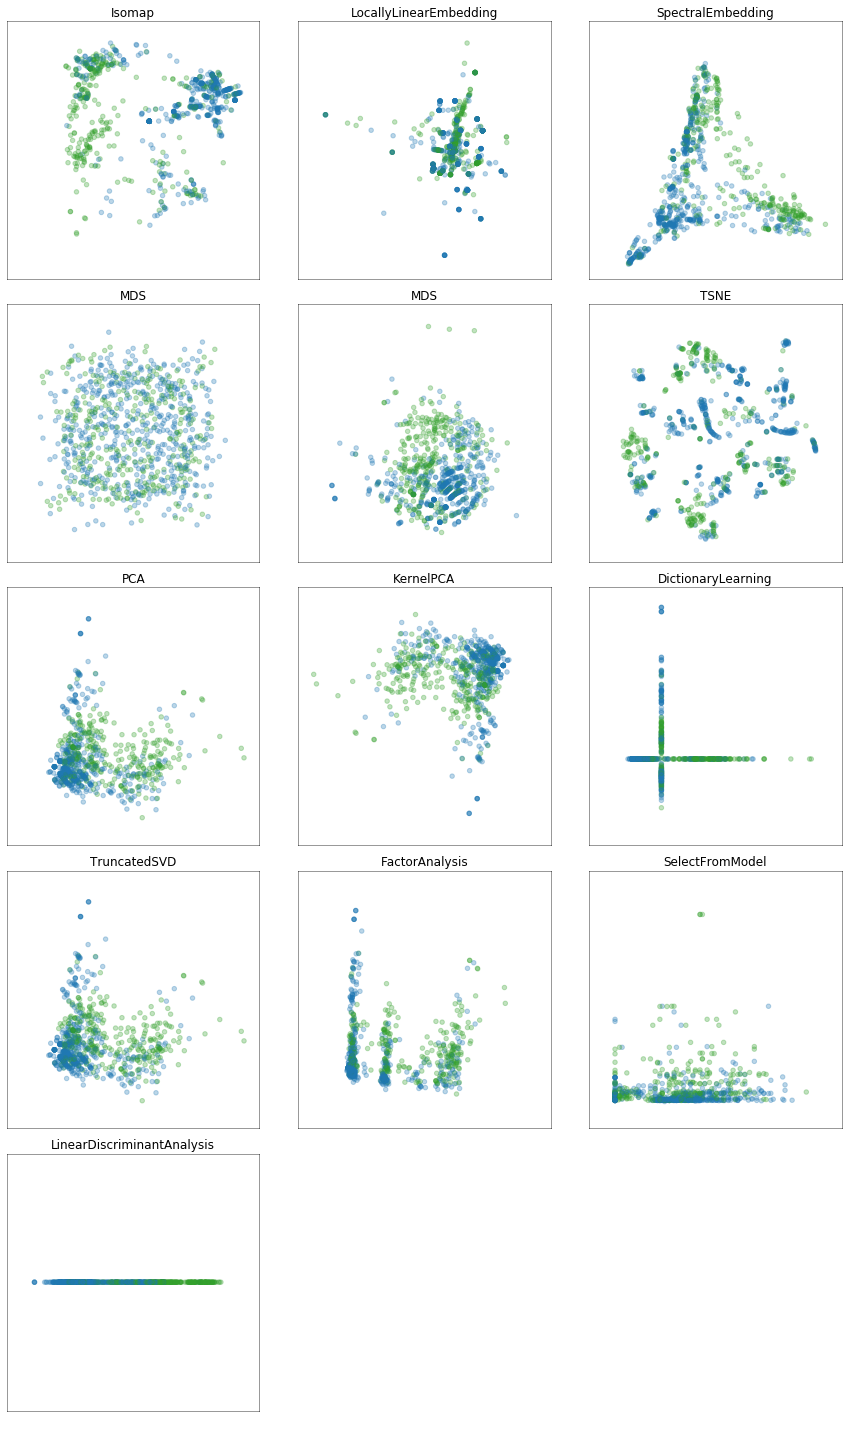

In [39]:
#================================================================================================
# USER INPUT!
# Check that the plot parameters are correct

fig, axes = plotall2Dreductions(allXypairs, clusteringtype=clusteringtype, predictiontype=predictiontype)

# Model evaluation

### Function making the final cross-validated predictions

In [40]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

# This function uses makeCrossValPredictionAndScore to make a cross-validated prediction for all the
# inputted models. However, it is also able to do this on a log-transformation of the y-values, as well
# as cap the predicted values to a minimum and maximum. Moreover, it can compute the Voting Regressor/Classifier
# of the inputted models.
@memory.cache
def finalCrossValPredictions(allXypairs, bestmodels, logtransformY, predictiontype="regression", minval=None, maxval=None, 
                            probability=False, includevoting=True):
    # We begin by transforming all the y-values
    if logtransformY==True and predictiontype=="regression":
        Ytransformer = FunctionTransformer(logtransform, inverse_func=invlogtransform)
    else:
        Ytransformer = FunctionTransformer()
    transformedallXypairs = [(Xmat, Ytransformer.transform(ymat)) for (Xmat, ymat) in allXypairs]
    # Now we make the required predictions with the given y-values
    allpredictions, weights = makeCrossValPredictionAndScore(bestmodels, transformedallXypairs, probability=probability)
    # We tag on the name of each prediction
    allpredictions = [(pred, getModelName(bestmodels[ii][0].steps[-1][1])) for ii,pred in enumerate(allpredictions)]
    # We will now make the voting prediction. If we're doing regression we may simply take the average of 
    # the best-performing models. If we're doing classification, we also take the average of the best (and round the result).
    # If we're not computing probabilities, we may also compute the result by taking the average of the probabilities
    # of the best-performing models.
    if predictiontype=="regression":
        votingregsandweights = listVotingRegressors(bestmodels)
        # Now we will take the best regressors and make a prediction with each of them
        votingpredictions= [allpredictions[ii][0] for ii,regr in enumerate(bestmodels) if regr in votingregsandweights]
        votingweights = [weights[ii] for ii,regr in enumerate(bestmodels) if regr in votingregsandweights]
        weightedaverage = np.dot(votingweights, votingpredictions) / np.sum(votingweights)
        allpredictions.append((weightedaverage, "Voting Regressor"))
    if predictiontype=="classification":
        votingclfsandweights = listVotingClassifiers(bestmodels)
        votingpredictions = [allpredictions[ii][0] for ii,clf in enumerate(bestmodels) if clf in votingclfsandweights]
        votingweights = [weights[ii] for ii,clf in enumerate(bestmodels) if clf in votingclfsandweights]
        weightedaverage = np.dot(votingweights, votingpredictions) / np.sum(votingweights)
        if probability==False:
            weightedaverage = np.round(weightedaverage).astype(int)
        allpredictions.append((weightedaverage, "Voting Classifier (direct)"))
        if probability==False:
            # We could also have computed probabilities for allpredictions right from the start,
            # instead of having to do recompute them for a subset of bestmodels. The reason we
            # don't do this is that votingClassifierCrossvalPredict doesn't work for all models
            # in bestmodels, generally. Also, the probabilities are much more expensive to compute
            # so it is silly to compute them for all models when we only want them for a subset of the models.
            allpredictions.append((votingClassifierCrossvalPredict(bestmodels, transformedallXypairs, probability=probability,
                                                                   voting="with_probas"), "Voting Classifier (with_probas)"))
    allpredictions = [(Ytransformer.inverse_transform(pred.reshape(1, -1)), predname) for (pred, predname) in allpredictions]
    # Now make sure all values are between certain values
    valuesofprediction = [pred[0] for pred in allpredictions]
    for predictvals in valuesofprediction:
        if maxval!=None:
            predictvals[predictvals>maxval] = maxval
        if minval!=None:
            predictvals[predictvals<minval] = minval
    return allpredictions

#### Helper function for cross-validated prediction

In [41]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def invlogtransform(inputdata):
    outputdata = deepcopy(inputdata)
    outputdata[outputdata>0] = np.expm1(outputdata[outputdata>0])
    outputdata[outputdata<0] = -np.expm1(-outputdata[outputdata<0])
    return outputdata

## Heteroscedasticity of errors

For regression problems we need to plot the heteroscedasticity of the fit. We will begin by plotting it for the two separate cases where the $y$-value has and has not been log-transformed (log-transforming usually improves heteroscedasticity).

We then pick the transformation we want to use when generating all the predictions.

### Function for plotting heteroscedasticity

In [42]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def plotHeteroscedComparison(allXypairs, bestregressors, minval=None, maxval=None):
    print "Blue dots show heteroscedasticity for normal predictions; green dots show the same when making a prediction on \
the log of the y-variable"
    normalprediction = finalCrossValPredictions(allXypairs, bestmodels, False, predictiontype="regression", 
                                                minval=minval, maxval=maxval, includevoting=True)
    logprediction = finalCrossValPredictions(allXypairs, bestmodels, True, predictiontype="regression", 
                                                minval=minval, maxval=maxval, includevoting=True)
    numberofrows = int(np.ceil(len(normalprediction) / 3.))
    fig, axes = plt.subplots(nrows=numberofrows, ncols=3, figsize=(12,4*numberofrows), tight_layout=True)
    ycolumn = allXypairs[-1][1]
    for (currentax, predicnorm, prediclog) in zip(axes.ravel(), normalprediction, logprediction):
        currentax.scatter(predicnorm[0], predicnorm[0].ravel()-ycolumn.ravel(), alpha=0.3, c="b")
        currentax.scatter(prediclog[0], prediclog[0].ravel()-ycolumn.ravel(), alpha=0.7, c="g")
        currentax.set_title(predicnorm[1])
        currentax.set_xlabel("Predicted "+ topredict)
        currentax.set_ylabel("Prediction Error")
    remainingaxes = axes.ravel()[len(normalprediction):]
    for currentax in remainingaxes:
        currentax.axis("off")

### Plot heteroscedasticities

In [43]:
#================================================================================================
# USER INPUT!
# Plot the heteroscedasticity. Decide whether the prediction should have a minimum and a maximum value
# (e.g. restricting Age to be between 0 and 115).

minval = 0 # Use None if there is no min
maxval = 115 # Use NOne if there is no max
bestmodels = bestclassifiers

#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

if clusteringtype=="supervised" and predictiontype=="regression":
    plotHeteroscedComparison(allXypairs, bestmodels, minval=minval, maxval=maxval)

### Make cross-validated predictions for all models

This will be useful for several different evluation functions. For classification we also compute the probabilities

In [44]:
#================================================================================================
# USER INPUT!
# Make the predictions, deciding on whether to use the log transform or not

logtransformY = False # if predictiontype=="classification" this should be False

if predictiontype=="classification":
    logtransformY = False
    minval = None
    maxval = None

#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

# Returns a list of models for which we may compute classification probabilities using makeCrossValPredictionAndScore
@memory.cache
def listSafeProbabilityModels(bestmodels, allXypairs):
    safemodels = []
    reducedXypairsets = [(X[:(len(X)/10+1)], y[:(len(X)/10+1)])for (X,y) in allXypairs]
    for mdl in bestmodels:
        try:
            thepredictions, theweights = makeCrossValPredictionAndScore([mdl], reducedXypairsets, probability=True)
            safemodels.append(mdl)
        except:
            pass
    return safemodels

if clusteringtype=="supervised":
    allpredictions = finalCrossValPredictions(allXypairs, bestmodels, logtransformY, predictiontype=predictiontype, 
                                              minval=minval, maxval=maxval, probability=False, includevoting=True)
    if predictiontype=="classification":
        safemodels = listSafeProbabilityModels(bestmodels, allXypairs)
        allprobapredictions = finalCrossValPredictions(allXypairs, safemodels, logtransformY, predictiontype=predictiontype, 
                                                       minval=minval, maxval=maxval, probability=True, includevoting=True)

## Score

### Function for scoring all prediction models

In [45]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

@memory.cache
def makeScoreAndStdDataframe(allXypairs, bestmodels, predictiontype, logtransformY=False, num_iterations=5, 
                             minval=None, maxval=None):
    if predictiontype=="regression":
        scoringmetric = sklearn.metrics.r2_score
    if predictiontype=="classification":
        scoringmetric = sklearn.metrics.accuracy_score
    multiplecrossvalpreds = [finalCrossValPredictions(allXypairs, bestmodels, logtransformY, predictiontype=predictiontype, 
                                                      minval=minval, maxval=maxval, probability=False, includevoting=True)
                             for i in range(num_iterations)]
    correctvalues = allXypairs[-1][1].ravel()
    allscores = np.transpose([[scoringmetric(correctvalues, pred[0].ravel()) for pred in allpredictions] 
                              for allpredictions in multiplecrossvalpreds])
    allscores = [[np.mean(scr), np.std(scr)] for scr in allscores]
    # Now we'll turn this into a dataframe for easier plotting
    mean_and_std_dataframe = pd.DataFrame(allscores, 
                                          index=[pred[1] for pred in allpredictions], 
                                          columns=["Mean","StandardDeviation"])
    return mean_and_std_dataframe

### Function for plotting the scores

In [46]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def plotScores(mean_and_std_dataframe):
    plot = mean_and_std_dataframe["Mean"].plot.bar(yerr=mean_and_std_dataframe["StandardDeviation"], color=lightBrewerColors(1))
    ymax = (mean_and_std_dataframe["Mean"] + mean_and_std_dataframe["StandardDeviation"]).max()*1.05
    plot.set_ylim([0,ymax])
    plot.set_title("Scores")
    return plot

### Plot the scores

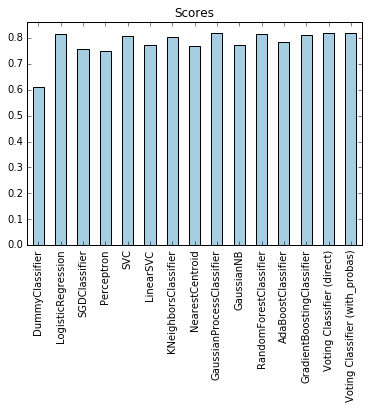

In [47]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

if clusteringtype=="supervised":
    mean_and_std_dataframe = makeScoreAndStdDataframe(allXypairs, bestmodels, predictiontype, num_iterations=5,
                                                      logtransformY=logtransformY, minval=minval, maxval=maxval)
    plot = plotScores(mean_and_std_dataframe)

## Clustering score

### Function for extracting clustering scores

In [48]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def makeClusterScoreAndStdDataframe(bestclusteringmethods):
    allscores = [[score, 0] for clustmethod, score, bestpos in bestclusteringmethods]
    names = [getModelName(clustmethod[-1].steps[-1][1]) for clustmethod, score, bestpos in bestclusteringmethods]
    mean_and_std_dataframe = pd.DataFrame(allscores, index=names, columns=["Mean","StandardDeviation"])
    return mean_and_std_dataframe

### Plot the clustering scores

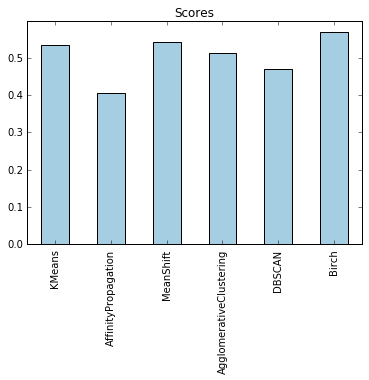

In [49]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

mean_and_std_dataframe = makeClusterScoreAndStdDataframe(bestclusteringmethods)
plot = plotScores(mean_and_std_dataframe)

## ROC

The ROC curve gives an estimate of how much better than random the prediction is, for *binary classification* tasks. By increasing the required probability of a "yes", we catch more true positives, but we also begin accidentally mislabeling data and hence also increase the rate of false positives.

### Functions for plotting ROC curves and their scores

In [50]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def plotROCcurves(allprobapredictions, ycolumn):
    allROCscores = []
    allnames = [probapred[1] for probapred in allprobapredictions]
    numberofrows = int(np.ceil(len(allprobapredictions) / 3.))
    fig, axes = plt.subplots(nrows=numberofrows, ncols=3, figsize=(12,4*numberofrows), tight_layout=True)
    for (currentax,probapred) in zip(axes.ravel(), allprobapredictions):
        predictedprobas = probapred[0].ravel()
        roc = roc_curve(ycolumn, predictedprobas)
        rocscore = roc_auc_score(ycolumn, predictedprobas)
        currentax.plot(roc[0], roc[1])
        currentax.plot([0,1],[0,1], linestyle="dashed", c="#4ca64c")
        currentax.set_title(probapred[1] + ": %f" % rocscore)
        currentax.set_xlabel("False positive rate")
        currentax.set_ylabel("True positive rate")
        allROCscores.append(rocscore)
    remainingaxes = axes.ravel()[len(allprobapredictions):]
    for currentax in remainingaxes:
        currentax.axis("off")
    return allROCscores, allnames

def plotROCscores(allROCscores, allnames):
    rocscoredataframe = pd.DataFrame(allROCscores, index=allnames, columns=["ROCScore"])
    plot = rocscoredataframe.plot.bar(color=lightBrewerColors(1), legend=False)
    ymax = rocscoredataframe.max().values*1.05
    plot.set_ylim([0,ymax])
    plot.set_title("ROC Scores")
    plot.axhline(y=0.5, linestyle="dashed", c="#4ca64c")
    return plot

### Plot ROC curves and scores

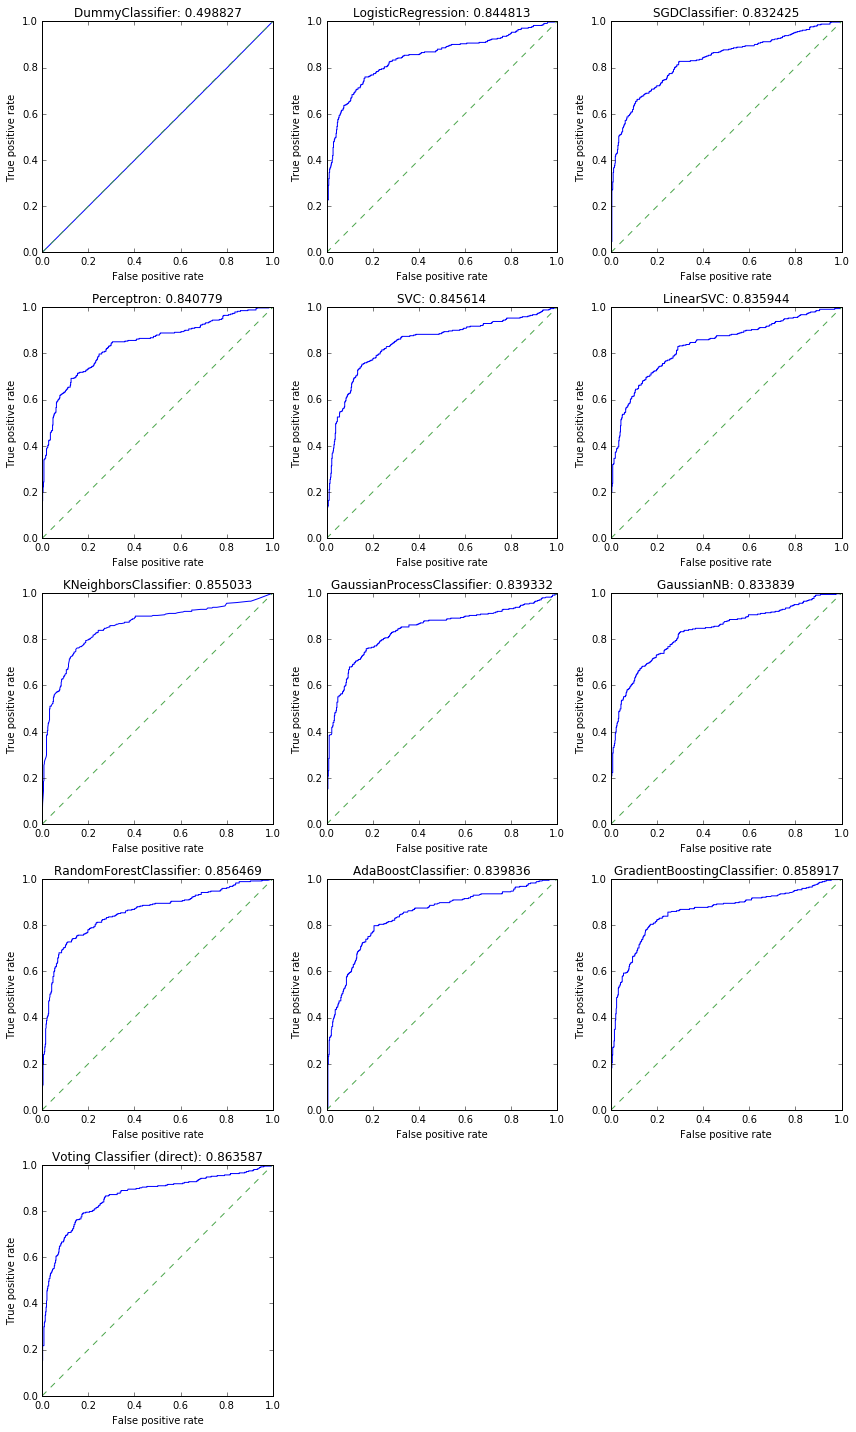

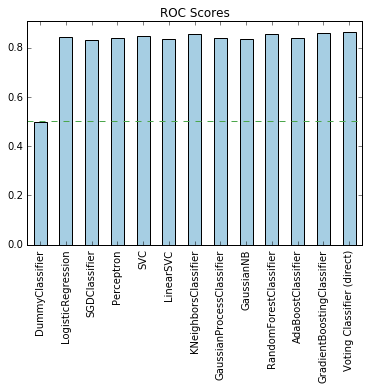

In [51]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

ycolumn = allXypairs[-1][1]

if clusteringtype=="supervised" and predictiontype=="classification" and len(np.unique(ycolumn.ravel()))==2:
    allROCscores, allnames = plotROCcurves(allprobapredictions, ycolumn)
    plotROCscores(allROCscores, allnames)    

## Precision-Recall curve

### Functions for plotting Precision-Recall curves and their scores

In [52]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def plotPrecisionRecallCurves(allprobapredictions, ycolumn):
    allPrecRecscores = []
    allnames = [probapred[1] for probapred in allprobapredictions]
    numberofrows = int(np.ceil(len(allprobapredictions) / 3.))
    fig, axes = plt.subplots(nrows=numberofrows, ncols=3, figsize=(12,4*numberofrows), tight_layout=True)
    for (currentax,probapred) in zip(axes.ravel(), allprobapredictions):
        predictedprobas = probapred[0].ravel()
        prec_rec = precision_recall_curve(ycolumn, predictedprobas)
        prec_rec_score = average_precision_score(ycolumn, predictedprobas)
        currentax.plot(prec_rec[0], prec_rec[1])
        currentax.set_title(probapred[1] + ": %f" % prec_rec_score)
        currentax.set_xlabel("Recall: tp/(tp+fp)")
        currentax.set_ylabel("Precision: tp/(tp+fn)")
        currentax.set_xlim([0,1])
        currentax.set_ylim([0,1])
        allPrecRecscores.append(prec_rec_score)
    remainingaxes = axes.ravel()[len(allprobapredictions):]
    for currentax in remainingaxes:
        currentax.axis("off")
    return allPrecRecscores, allnames

def plotPrecisionRecallScores(allPrecRecscores, allnames, allpredictions, ycolumn):
    precrecdataframe = pd.DataFrame(allPrecRecscores, index=allnames, columns=["Precision-Recall Score"])
    # We will also compiute the F1 scores, which are sometimes used as a measure of precision and recall
    f1scores = [f1_score(ycolumn.ravel(), pred[0].ravel()) for pred in allpredictions]
    modelnames = [pred[1] for pred in allpredictions]
    f1dataframe = pd.DataFrame(f1scores, index=modelnames, columns=["F1 Score"])
    
    concatenatedframe = pd.concat([precrecdataframe, f1dataframe], axis=1).fillna(0)
    maxvalue = concatenatedframe.values.ravel().max()
    
    plot = concatenatedframe.plot.bar(color=[lightBrewerColors()[0], lightBrewerColors()[2]])
    plot.set_ylim([0,maxvalue*1.3])
    plot.set_title("Precision-Recall Scores")
    return plot

### Plot ROC curves and scores

Recall: Proportion of (positive) predictions that are correct.
Precision: Proportion of positives I managed to predict.


C:\Users\Daniele\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


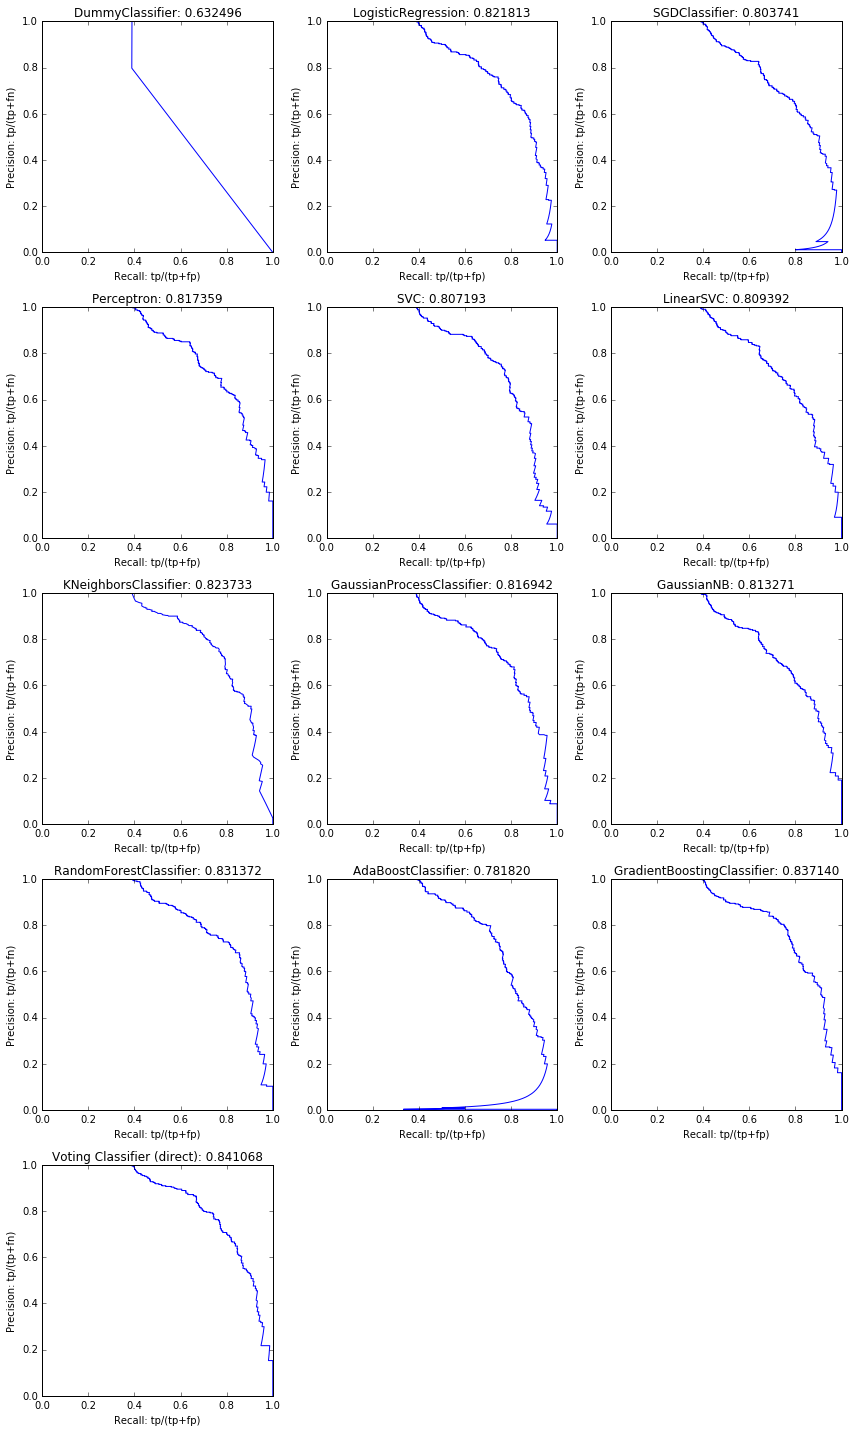

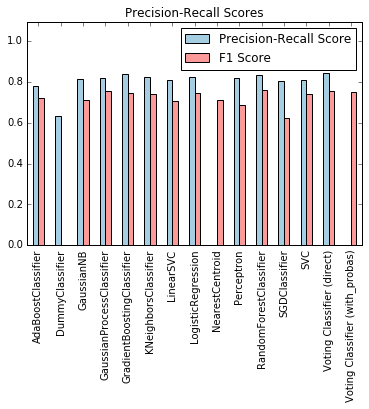

In [53]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

ycolumn = allXypairs[-1][1]

if clusteringtype=="supervised" and predictiontype=="classification" and len(np.unique(ycolumn.ravel()))==2:
    print "Recall: Proportion of (positive) predictions that are correct."
    print "Precision: Proportion of positives I managed to predict."
    allPrecRecscores, allnames = plotPrecisionRecallCurves(allprobapredictions, ycolumn)
    plotPrecisionRecallScores(allPrecRecscores, allnames, allpredictions, ycolumn)

## Confusion matrix

### Function for plotting confusion matrices

In [54]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

# This is largely based on an example on sklearn's website
def plotConfusionMatrices(allpredictions, ycolumn, normalize=False):
    classes = np.unique(ycolumn.ravel())
    tick_marks = np.arange(len(classes))

    trueycolumn = ycolumn.ravel()
    numberofrows = int(np.ceil(len(allpredictions) / 3.))
    fig, axes = plt.subplots(nrows=numberofrows, ncols=3, figsize=(12,4*numberofrows), tight_layout=True)
    for (currentax,pred) in zip(axes.ravel(), allpredictions):
        confmatrix = confusion_matrix(trueycolumn, pred[0].ravel())
        axisimage = currentax.imshow(confmatrix, interpolation='nearest', cmap=plt.cm.Blues)
        currentax.set_title(pred[1])
        currentax.set_xticks(tick_marks)
        currentax.set_xticklabels(classes, rotation=45)
        currentax.set_yticks(tick_marks)
        currentax.set_yticklabels(classes)
        if normalize:
            confmatrix = confmatrix.astype('float') / confmatrix.ravel().sum()
        thresh = confmatrix.max() / 2.
        for i, j in itertools.product(range(confmatrix.shape[0]), range(confmatrix.shape[1])):
            currentax.text(j, i, np.round(confmatrix[i, j], decimals=3), horizontalalignment="center",
                           color="white" if confmatrix[i, j] > thresh else "black")
        currentax.set_xlabel("True label")
        currentax.set_ylabel("Predicted label")
        fig.colorbar(axisimage, ax=currentax, shrink=0.68)
    return fig, axes

### Plot ROC curves and scores

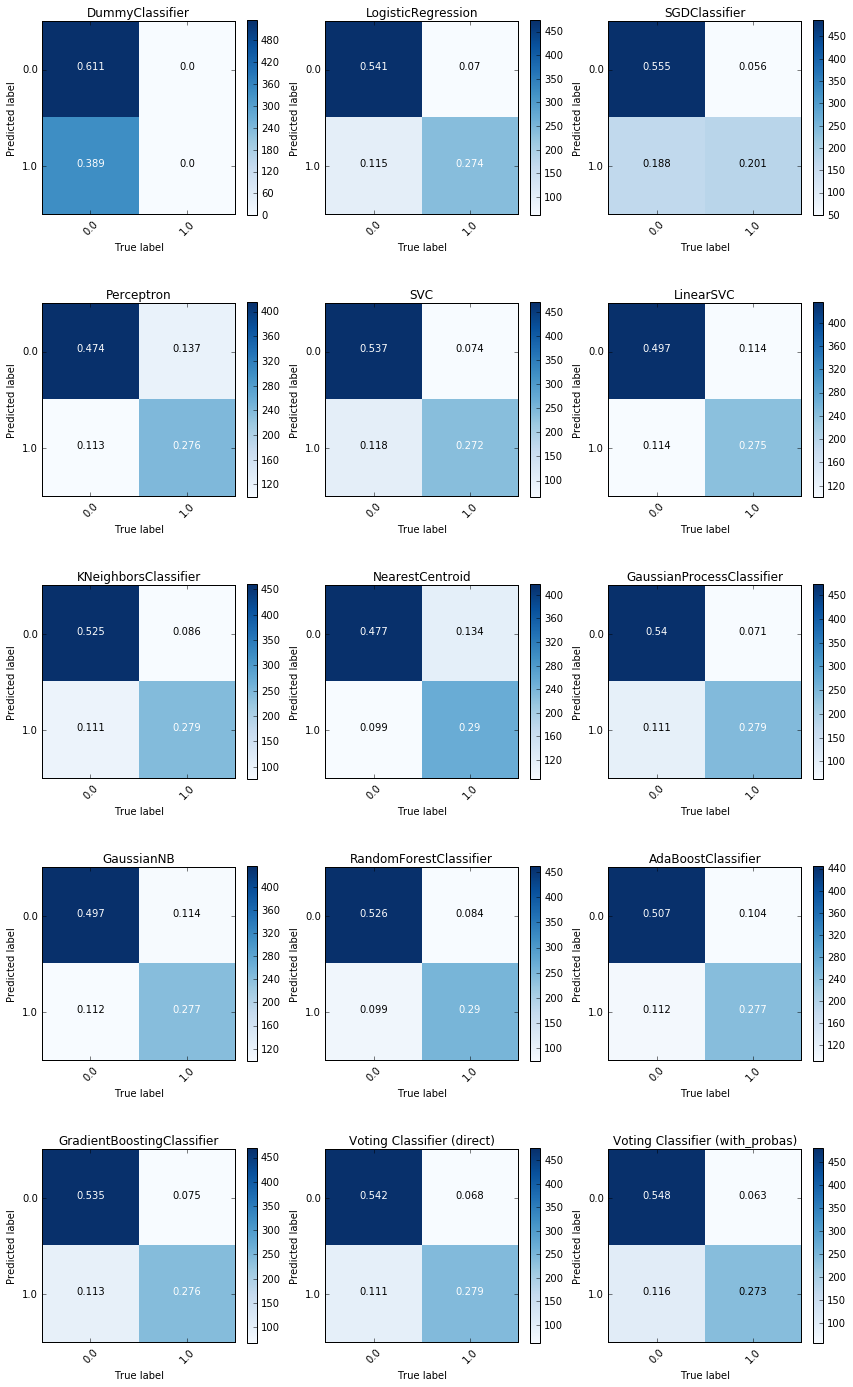

In [55]:
#================================================================================================
# USER INPUT!

normalizenumebers = True

#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

fig, axes = plotConfusionMatrices(allpredictions, ycolumn, normalize=normalizenumebers)

## Validation curve and learning curve

### Validation curve
We have already chosen the best hyperparameters for each model. It may still be interesting to plot this dependence, to see how sensitive a given model is to one of its hyperparameters. This may tell you when your model starts to overfit, as it plots both the training score and the validation score.

In [195]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def plotValidationCurve(allXypairs, modeltotest, parametertotest, iterations):
    themodel = modeltotest[0]
    X,y = allXypairs[modeltotest[-1]]
    traintestscores = [validation_curve(themodel, X, y.ravel(), parametertotest[0], parametertotest[1], cv=crossvalidator) 
                       for jj in range(iterations)]
    meantrainscore = [np.mean(el) for el in np.transpose([[np.mean(el) for el in trainsc] 
                                                          for trainsc,testsc in traintestscores])]
    meantestscore = [np.mean(el) for el in np.transpose([[np.mean(el) for el in testsc] 
                                                         for trainsc,testsc in traintestscores])]
    plt.plot(parametertotest[1], meantrainscore, label='Training', color=darkBrewerColors()[3])
    plt.plot(parametertotest[1], meantestscore, label='Validation', color=darkBrewerColors()[0])
    plt.legend()
    plt.title(getModelName(themodel.steps[-1][1]))
    postostartfrom = parametertotest[0].find("__")
    if postostartfrom!=-1:
        plt.xlabel(parametertotest[0][postostartfrom+2:])
    else:
        plt.xlabel(parametertotest[0])
    plt.ylabel("Score")

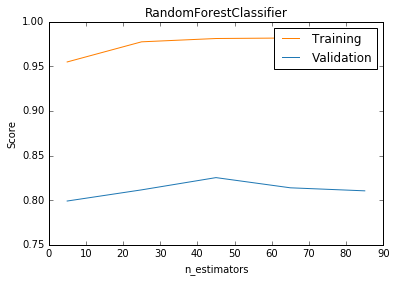

In [196]:
#================================================================================================
# USER INPUT!

modeltotest = bestmodels[10]
parametertotest = ["randforest__n_estimators", np.arange(5,100,20)]
iterations = 1

#================================================================================================
# FROM HERE ON IT'S AUTOMATIC
    
plotValidationCurve(allXypairs, modeltotest, parametertotest, iterations)

### Learning curve

Tells you whether, for a given model (with specific hyperparameters), you benefit from adding samples. If the answer is no, it might be beneficial to increase the complexity of the model.

In [220]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def plotLearningCurve(allXypairs, modeltotest, train_sizes, iterations):
    themodel = modeltotest[0]
    X,y = allXypairs[modeltotest[-1]]
    traintestscores = [learning_curve(themodel, X, y.ravel(), train_sizes=train_sizes, cv=crossvalidator)
                       for jj in range(iterations)]
    meantrainscore = [np.mean(el) for el in np.transpose([[np.mean(el) for el in trainsc]
                                                          for train_sizes, trainsc,testsc in traintestscores])]
    meantestscore = [np.mean(el) for el in np.transpose([[np.mean(el) for el in testsc] 
                                                         for train_sizes,trainsc,testsc in traintestscores])]
    plt.plot(train_sizes, meantrainscore, label='Training', color=darkBrewerColors()[3])
    plt.plot(train_sizes, meantestscore, label='Validation', color=darkBrewerColors()[0])
    plt.legend()
    plt.title(getModelName(themodel.steps[-1][1]))
    plt.xlabel("Size of test-data")
    plt.ylabel("Score")

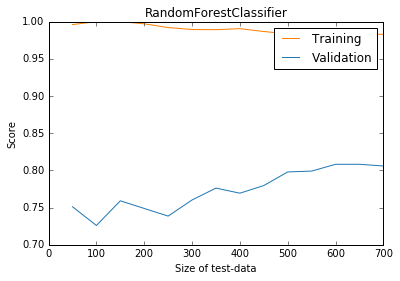

In [221]:
#================================================================================================
# USER INPUT!

modeltotest = bestmodels[10]
train_sizes = np.arange(50,np.round(0.8*len(X)), 50).astype(int)
iterations = 1

#================================================================================================
# FROM HERE ON IT'S AUTOMATIC
    
plotLearningCurve(allXypairs, modeltotest, train_sizes, iterations)

## Probability estimates and Brier score

Here we plot the quality of the calibrated probability estimates of the various models, and rank them by their Brier score.

### Functions for probabilities and their scores

In [273]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

def plotProbabilityCurves(allprobapredictions, ycolumn):
    allBrierscores = []
    allnames = [probapred[1] for probapred in allprobapredictions]
    numberofrows = int(np.ceil(len(allprobapredictions) / 3.))
    fig, axes = plt.subplots(nrows=numberofrows, ncols=3, figsize=(12,4*numberofrows), tight_layout=True)
    for (currentax,probapred) in zip(axes.ravel(), allprobapredictions):
        predictedprobas = probapred[0].ravel()
        answers, probas = calibration_curve(ycolumn, predictedprobas, n_bins=10)
        brierscore = 1.-brier_score_loss(ycolumn, predictedprobas)
        currentax.plot([0,1],[0,1], "k:")
        currentax.plot(probas, answers, "s-", label = "Probability prediction")
        currentax.set_title("Reliability of probability prediction:\n" + probapred[1])
        currentax.set_xlabel("Predicted probaiblity")
        currentax.set_ylabel("True probability")
        allBrierscores.append(brierscore)
    remainingaxes = axes.ravel()[len(allprobapredictions):]
    for currentax in remainingaxes:
        currentax.axis("off")
    return allBrierscores, allnames

def plotBrierScores(allBrierscores, allnames):
    brierscoredataframe = pd.DataFrame(allBrierscores, index=allnames, columns=["BrierScore"])
    plot = brierscoredataframe.plot.bar(color=lightBrewerColors(1), legend=False)
    ymax = brierscoredataframe.max().values*1.05
    plot.set_ylim([0,ymax])
    plot.set_title("Brier Scores")
    #plot.axhline(y=0.5, linestyle="dashed", c="#4ca64c")
    return plot

### Plot probabilities and scores

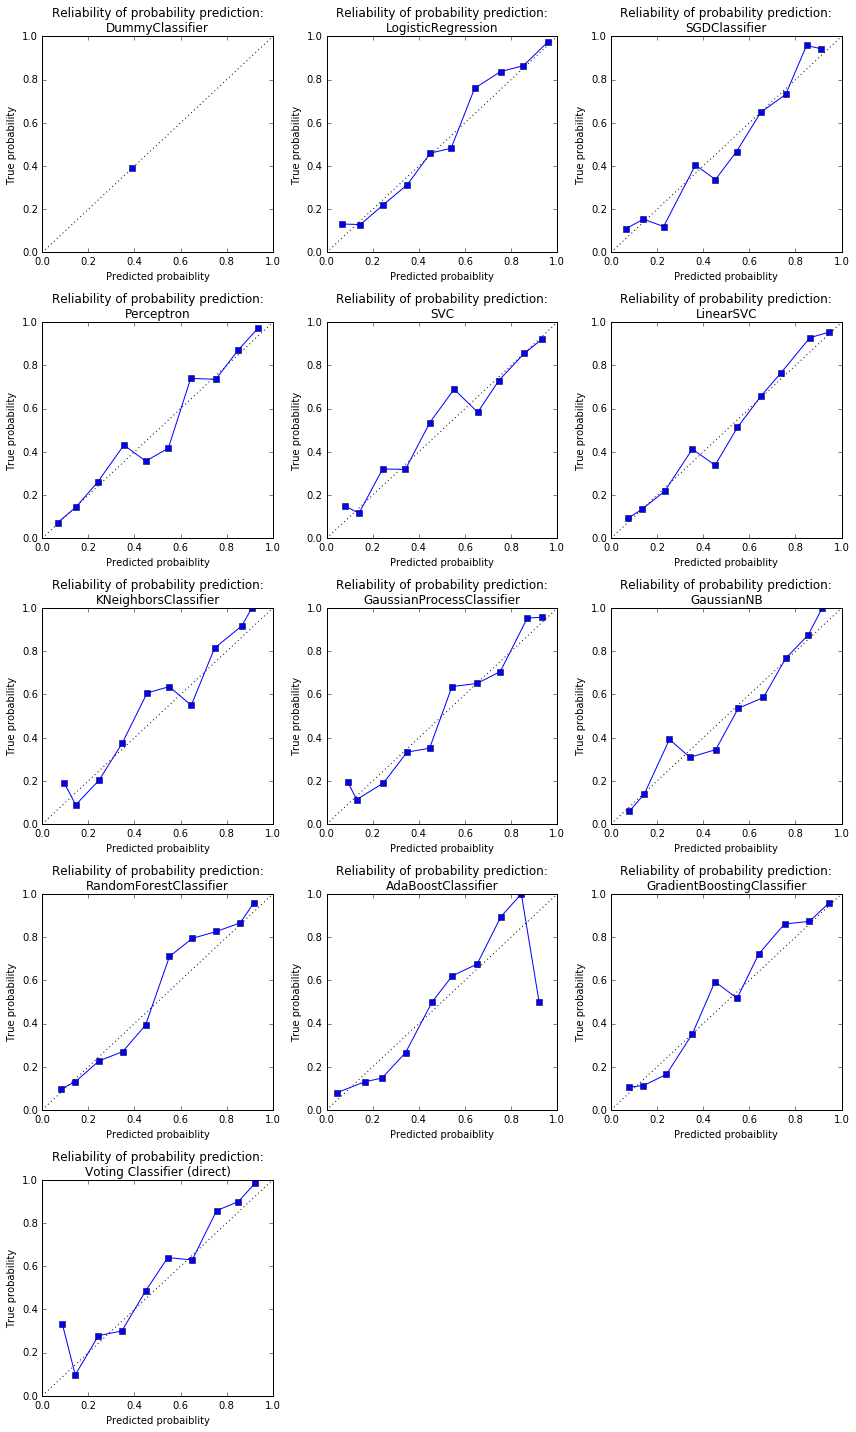

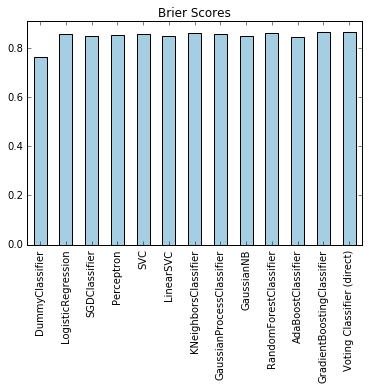

In [274]:
#================================================================================================
# FROM HERE ON IT'S AUTOMATIC

ycolumn = allXypairs[-1][1]

if clusteringtype=="supervised" and predictiontype=="classification" and len(np.unique(ycolumn.ravel()))==2:
    allBrierscores, allnames = plotProbabilityCurves(allprobapredictions, ycolumn)
    plotBrierScores(allBrierscores, allnames)  

# Temporary work

## Regression
### Functions for making predictions based on given model

In [4]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

# Returns the intercept, parameters, Rscore (where 1.0 is perfect prediction, and percentage of cases
# correctly predicted. The final two are given as tuple (score, errorbarsonscore). X is the data we use 
# to predict y; predictionmethod is the name of our model, e.g. LinearRegression; rounddecimals
# equals the number of decimals allowed for our prediction, e.g. when predicting integers rounddecimals=0; 
# num_iterations is the number of times we run the function to obtain the parameters, and kwargs are any 
# additional optional parameters we want to pass on to predictionmethod.
def getParametersAndPredictionScore(inputX, inputy, predictionmethod, rounddecimals="none", num_iterations=1, 
                                    classifier=False, transform="none",**kwargs):
    (X, y) = (inputX, inputy)
    if transform!="none":
        (X, y) = (transformData(inputX, transform=transform), transformData(inputy, transform=transform))
    if classifier==True:
        predictedpercent = []
    parameters = []
    intercept = []
    score = []
    for iter in range(num_iterations):
        kfoldindices = KFold(len(y),n_folds=5,shuffle=True)
        for trainindex, testindex in kfoldindices:
            Xtrain, Xtest = X[trainindex], X[testindex]
            if transform=="scale":
                (Xtrain, Xtest) = scaleData(Xtrain, Xtest)
            ytrain, ytest = y[trainindex], y[testindex]
            predictor = predictionmethod(**kwargs)
            predictor.fit(Xtrain,ytrain)
            predictedy = predictor.predict(Xtest)
            if rounddecimals!="none":
                predictedy = np.round(predictedy, decimals=rounddecimals)
            if classifier==True:
                predictedpercent.append((predictedy==ytest).mean())
            parameters.append(predictor.coef_)
            intercept.append(predictor.intercept_)
            score.append(predictor.score(Xtest,ytest))
    score = (np.mean(score),np.std(score))
    parameters = np.mean(parameters, axis=0)
    intercept = np.mean(intercept)
    if classifier==True:
        predictedpercent = (np.mean(predictedpercent), np.std(predictedpercent))
        toreturn = (intercept, parameters, score, predictedpercent)
    else:
        toreturn = (intercept, parameters, score)
    return toreturn

def getPredictionPercentage(inputX, inputy, predictionmethod, rounddecimals="none", num_iterations=1, 
                                    classifier=False, transform="none",**kwargs):
    (X, y) = (inputX, inputy)
    if transform!="none":
        (X, y) = (transformData(inputX, transform=transform), transformData(inputy, transform=transform))
    if classifier==True:
        predictedpercent = []
    score = []
    for iter in range(num_iterations):
        kfoldindices = KFold(len(y),n_folds=5,shuffle=True)
        for trainindex, testindex in kfoldindices:
            Xtrain, Xtest = X[trainindex], X[testindex]
            if transform=="scale":
                (Xtrain, Xtest) = scaleData(Xtrain, Xtest)
            ytrain, ytest = y[trainindex], y[testindex]
            predictor = predictionmethod(**kwargs)
            predictor.fit(Xtrain,ytrain)
            predictedy = predictor.predict(Xtest)
            if rounddecimals!="none":
                predictedy = np.round(predictedy, decimals=rounddecimals)
            if classifier==True:
                predictedpercent.append((predictedy==ytest).mean())
            score.append(predictor.score(Xtest,ytest))
    score = (np.mean(score),np.std(score))
    if classifier==True:
        predictedpercent = (np.mean(predictedpercent), np.std(predictedpercent))
        toreturn = (score, predictedpercent)
    else:
        toreturn = (score)
    return toreturn

# Returns the prediction accuracy (+/- errorbars on the accuracy) when classifying "at random", i.e. 
# by always predicting the same thing for all the elements. We try by predicting the mean, or the 
# median, or the most frequently occurring element
#---------------------------------------
# SHOULD USE DummyClassifier INSTEAD!!!
#---------------------------------------
def randomPrediction(y, rounddecimals="none", num_iterations=1):
    meanscore = []
    medianscore = []
    mostfrequentscore = []
    for iter in range(num_iterations):
        kfoldindices = KFold(len(y),n_folds=5,shuffle=True)
        for trainindex, testindex in kfoldindices:
            ytrain, ytest = y[trainindex], y[testindex]
            mean = np.mean(ytrain)
            median = np.median(ytrain)
            mostfrequent = max(set(list(y)), key=list(ytrain).count)
            if rounddecimals!="none":
                mean = np.round(mean, decimals=rounddecimals)
            meanscore.append((ytest==mean).mean())
            medianscore.append((ytest==median).mean())
            mostfrequentscore.append((ytest==mostfrequent).mean())
    meanscore = (np.mean(meanscore), np.std(meanscore))
    medianscore = (np.mean(medianscore), np.std(medianscore))
    mostfrequentscore = (np.mean(mostfrequentscore), np.std(mostfrequentscore))
    allscores = [meanscore[0], medianscore[0], mostfrequentscore[0]]
    return [meanscore, medianscore, mostfrequentscore][allscores.index(max(allscores))]

#### Helper functions

In [5]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

def transformData(inputdata, transform="log"):
    outputdata = deepcopy(inputdata)
    if transform=="sqrt":
        outputdata[outputdata>0] = np.sqrt(outputdata[outputdata>0])
        outputdata[outputdata<0] = -np.sqrt(-outputdata[outputdata<0])
    if transform=="log":
        #----------------------------
        # USE np.log1p !!!!
        #----------------------------
        outputdata[outputdata>1] = np.log(outputdata[outputdata>1])+1
        outputdata[outputdata<-1] = -np.log(-outputdata[outputdata<-1])-1
    return outputdata

def inverseTransformData(inputdata, transform="log"):
    outputdata = deepcopy(inputdata)
    if transform=="sqrt":
        outputdata[outputdata>0] = outputdata[outputdata>0]**2
        outputdata[outputdata<0] = -((-outputdata[outputdata<0])**2)
    if transform=="log":
        outputdata[outputdata>1] = np.e**(outputdata[outputdata>1]-1)
        outputdata[outputdata<-1] = -(np.e**(-outputdata[outputdata<-1] -1))
    return outputdata



#This function removes those rows in "inputdataframe" where data was generated automatially 
# in the column "columnofinterest". "dictofunknown" contains the information on what data was
# generated automatically.
def removeAutogeneratedData(inputdataframe, columnsofinterest, dictofunknown):
    if type(columnsofinterest)==str:
        allcolumnsofinterest = [columnsofinterest]
    else:
        allcolumnsofinterest = columnsofinterest
    outputdataframe = deepcopy(inputdataframe)
    for col in allcolumnsofinterest:
        if col in dictofunknown:
            outputdataframe = outputdataframe[outputdataframe[col]!= dictofunknown[col]]
    return outputdataframe

# Helper function that takes a model, e.g. linear_model.LinearRegression,
# and returns the name of that model, e.g. "LinearRegression"
def getModelName(currentmodel):
    modelname = str(currentmodel)
    modelname = modelname[modelname.rfind(".")+1:]
    extracharacters = re.search("[^a-zA-z]",modelname)
    if type(extracharacters)!=type(None):
        modelname = modelname[:extracharacters.start()]
    return modelname

### Implement all linear regressions

In [6]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

def tryAllLinearRegressions(thedataframe, topredict, frompredict, dictofunknown={}, num_iterations=100, 
                            rounddecimals="none", printout=False, classifier=False, transform="none"):
    # We begin by making the input data from thedataframe
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    
    modelstotryout = [LinearRegression, RidgeCV, LassoCV, 
                      BayesianRidge, SGDRegressor]
    
    if classifier==True:
        randomprediction = randomPrediction(y, rounddecimals=rounddecimals, num_iterations=num_iterations)
    modelandresults = {}
    for model in modelstotryout:
        modelname = getModelName(model)
        if printout==True:
            print modelname
        transformtouse = transform
        if model==SGDRegressor:
            transformtouse = "scale"
        if "n_alphas" in model().get_params():
            modeldata = getParametersAndPredictionScore(X, y, model, rounddecimals=rounddecimals, 
                                                        num_iterations=num_iterations, n_alphas=3,
                                                        classifier=classifier, transform=transformtouse)
        else:
            modeldata = getParametersAndPredictionScore(X, y, model, rounddecimals=rounddecimals, 
                                                        num_iterations=num_iterations, classifier=classifier,
                                                        transform=transformtouse)
        modelandresults[modelname] = modeldata
        if printout==True:
            print u"\tThe score on the fit is %f \u00B1 %f (1.0 is perfect)" %modeldata[2]
            if classifier==True:
                print u"\tThe percentage of correct identifications is: %f \u00B1 %f" %modeldata[-1]
                print u"\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
    return modelandresults

### Function for plotting heteroscedasticity

In [ ]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

# Makes a scatterplot of the error in prediction, versus the predicted value, to see if there
# is any heteroscedasticity, i.e. to see if the error bars of our prediction depend on the value
# of the prediction. Returns the R^2 value of the prediction.
def plotErrors(thedataframe, topredict, frompredict, chosenmodel, dictofregressions, 
               rounddecimals="none", minvalue="none", maxvalue="none", ax="none", dictofunknown={}, 
               alpha=0.3, transform="none"):
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    if transform!="none":
        X = transformData(X, transform=transform)
    coefficients = dictofregressions[chosenmodel][1]
    intercept = dictofregressions[chosenmodel][0]
    prediction = np.dot(X,coefficients) + intercept
    if transform!="none":
        prediction = inverseTransformData(prediction, transform=transform)
    if rounddecimals!="none":
        prediction = np.round(prediction, decimals=rounddecimals)
    if minvalue!="none":
        prediction[prediction < minvalue] = minvalue
    if maxvalue!="none":
        prediction[prediction > maxvalue] = maxvalue
    if ax=="none":
        plt.scatter(prediction, prediction - y, alpha=alpha)
        plt.xlabel("Predicted " + topredict)
        plt.ylabel("Error in prediction")
        plt.show()
    else:
        ax.scatter(prediction, prediction - y, alpha=alpha)
        ax.set_xlabel("Predicted " + topredict)
        ax.set_ylabel("Error in prediction")
    print "Mean: %f" %np.mean(prediction - y)
    print "Std: %f" %np.std(prediction - y)
    print "R^2: %f" %(np.var(prediction) / np.var(y))

#### Helper functions

In [7]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

def makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown):
    tousedataframe = removeAutogeneratedData(thedataframe, frompredict + [topredict], dictofunknown)
    X = tousedataframe[frompredict].as_matrix()
    y = tousedataframe[topredict].as_matrix()
    return (X,y)

### Functions for using regressions to fill in unknown data

In [8]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

# Makes a dataframe where the values of topredict have been predicted using frompredict, with the regression 
# model called chosenmodel (a string). For this we need to have found all regressions, placed in the variable
# dictofregressions.
def incorporateRegressionPrediction(inputdataframe, topredict, frompredict, chosenmodel, dictofregressions,
                                    rounddecimals="none", minvalue="none", maxvalue="none", transform="none"):
    thedataframe = deepcopy(inputdataframe)
    if topredict in dictofunknown:
        topredictframe = thedataframe[thedataframe[topredict]==dictofunknown[topredict]]
    else:
        topredictframe = thedataframe[thedataframe[topredict].isnull()]
    ind = topredictframe.index
    dataX = topredictframe[frompredict].as_matrix()
    if transform!="none":
        dataX = transformData(dataX, transform=transform)
    if len(dataX) > 0:
        coefficients = dictofregressions[chosenmodel][1]
        intercept = dictofregressions[chosenmodel][0]
        prediction = np.dot(dataX,coefficients) + intercept
        if transform!="none":
            prediction = inverseTransformData(prediction, transform=transform)
        if rounddecimals!="none":
            prediction = np.round(prediction, decimals=rounddecimals)
        if minvalue!="none":
            prediction[prediction < minvalue] = minvalue
        if maxvalue!="none":
            prediction[prediction > maxvalue] = maxvalue
        thedataframe.loc[ind, topredict] = prediction
    return thedataframe

### Use linear regression for missing data

After having tried various options, it seems like using transform="log" we're able to avoid most of the heteroscedasticity we otherwise get with a straightforward linear regression.

In [9]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

numericdataframe = makeAllColumnsNumeric(thedataframe, dictofordinals, datacateg)[0]
topredict = "Age"
frompredict = ['Pclass', 'Sex', 'SibSp', 'Parch', "Fare", "Cabin", 'Embarked']
tousedataframe = deepcopy(numericdataframe)
transform = "log"

linearregressions = tryAllLinearRegressions(tousedataframe, topredict, frompredict,
                                            dictofunknown={'Age': 29.6991176471}, printout=True, num_iterations=100, 
                                            rounddecimals="none", classifier=False, transform=transform)

LinearRegression
	The score on the fit is 0.231831 ± 0.072196 (1.0 is perfect)
RidgeCV
	The score on the fit is 0.226336 ± 0.076700 (1.0 is perfect)
LassoCV
	The score on the fit is 0.235617 ± 0.067838 (1.0 is perfect)
BayesianRidge
	The score on the fit is 0.230975 ± 0.073355 (1.0 is perfect)
SGDRegressor
	The score on the fit is 0.210152 ± 0.062698 (1.0 is perfect)


### Check heteroscedasticity of fit

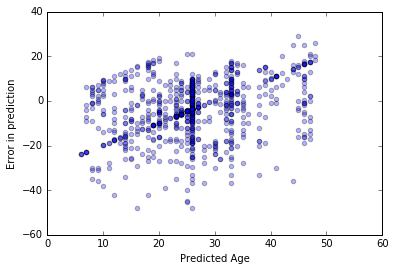

Mean: -3.667033
Std: 12.409790
R^2: 0.492753


In [10]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

chosenmodel = "LinearRegression"
dictofregressions = linearregressions
rounddecimals=0
minvalue=0
maxvalue=100

plotErrors(tousedataframe, topredict, frompredict, chosenmodel, dictofregressions,
           rounddecimals=rounddecimals, minvalue=minvalue, maxvalue=maxvalue, ax="none", transform=transform)

### Make new datafram with predicted values

In [11]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

newdataframe = incorporateRegressionPrediction(tousedataframe, topredict, frompredict, chosenmodel, dictofregressions,
                                               rounddecimals=rounddecimals, minvalue=minvalue, maxvalue=maxvalue, 
                                               transform=transform)

## Classification
### Generic functions for making predictions and checking their accuracy

In [12]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================


def getPrediction(trainX, trainy, dataX, predictionmethod, transform="none",**kwargs):
    (Xtraining, ytraining) = (trainX, trainy)
    X = dataX
    if transform!="none":
        Xtraining = transformData(trainX, transform=transform)
        X = transformData(dataX, transform=transform)
    if transform=="scale":
        (Xtraining, X) = scaleData(Xtraining, X)
    predictor = predictionmethod(**kwargs)
    predictor.fit(Xtraining,ytraining)
    predictedy = predictor.predict(X)
    return predictedy

def getPredictionProba(trainX, trainy, dataX, predictionmethod, transform="none",**kwargs):
    (Xtraining, ytraining) = (trainX, trainy)
    X = dataX
    if transform!="none":
        Xtraining = transformData(trainX, transform=transform)
        X = transformData(dataX, transform=transform)
    if transform=="scale":
        (Xtraining, X) = scaleData(Xtraining, X)
    predictor = predictionmethod(**kwargs)
    predictor.fit(Xtraining,ytraining)
    predictedy = predictor.predict_proba(X)
    return predictedy

def getPredictionScore(inputX, inputy, predictionmethod, num_iterations=1, transform="none",**kwargs):
    (X, y) = (inputX, inputy)
    if transform!="none":
        X = transformData(inputX, transform=transform)
    score = []
    for iter in range(num_iterations):
        kfoldindices = KFold(len(y),n_folds=5,shuffle=True)
        for trainindex, testindex in kfoldindices:
            Xtrain, Xtest = X[trainindex], X[testindex]
            if transform=="scale":
                (Xtrain, Xtest) = scaleData(Xtrain, Xtest)
            ytrain, ytest = y[trainindex], y[testindex]
            predictor = predictionmethod(**kwargs)
            predictor.fit(Xtrain,ytrain)
            score.append(predictor.score(Xtest,ytest))
    score = (np.mean(score),np.std(score))
    return score

### Functions for making classification through regression

In [13]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================


def tryAllLinRegClassifiers(thedataframe, topredict, frompredict, dictofunknown={}, num_iterations=30, 
                            rounddecimals=0, printout=True, transform="scale", polynomialdegrees=[1]):
    linregs = tryPolynomialRegressions(thedataframe, topredict, frompredict, polynomialdegrees,
                                       dictofunknown=dictofunknown, num_iterations=num_iterations,
                                       rounddecimals=rounddecimals, printout=printout, classifier=True, transform=transform)
    otherregs = tryOtherRegressions(thedataframe, topredict, frompredict,
                                    dictofunknown=dictofunknown, num_iterations=num_iterations,
                                    rounddecimals=rounddecimals, printout=printout, classifier=True, transform="none")
    linregs.update(otherregs)
    regclassifiers = tryAllRegressionClassifiers(thedataframe, topredict, frompredict, polynomialdegrees, 
                                                 dictofunknown=dictofunknown, num_iterations=num_iterations, 
                                                 printout=printout, transform=transform)
    linregs.update(regclassifiers)
    otherclass = tryOtherClassifiers(thedataframe, topredict, frompredict, dictofunknown=dictofunknown, 
                                     num_iterations=num_iterations, printout=printout, transform=transform)
    linregs.update(otherclass)
    return linregs

#### Helper functions

In [14]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================


def tryAllRegressionClassifiers(thedataframe, topredict, frompredict, polynomialdegrees, dictofunknown={}, num_iterations=100, 
                            printout=False, transform="none"):
    # We begin by making the input data from thedataframe
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    
    modelstotryout = [LogisticRegression, LogisticRegressionCV, SGDClassifier, Perceptron]
    
    if type(polynomialdegrees)==int:
        alldegrees = [polynomialdegrees]
    else:
        alldegrees = polynomialdegrees
    
    randomprediction = randomPrediction(y, num_iterations=num_iterations)
    
    modelandresults = {}
    for model in modelstotryout:
        modelname = getModelName(model)
        if printout==True:
            print modelname
        transformtouse = transform
        if model==SGDClassifier or model==Perceptron:
            transformtouse = "scale"
        for polydegree in alldegrees:
            poly = PolynomialFeatures(degree=polydegree)
            polyX = poly.fit_transform(X)
            if printout==True:
                print "\tPolynomial of degree " + str(polydegree)
            if "n_alphas" in model().get_params(): 
                modelscore = getPredictionScore(polyX, y, model, num_iterations=num_iterations, n_alphas=3, 
                                                transform=transformtouse)
            else:
                modelscore = getPredictionScore(polyX, y, model, num_iterations=num_iterations, transform=transformtouse)
            modelandresults[modelname] = modelscore
            if printout==True:
                print u"\t\tThe percentage of correct identifications is: %f \u00B1 %f" %modelscore
                print u"\t\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
            # Now we'll do the Bagging version of this same model
            if printout==True:
                print "\t    Bagging version"
            if "n_alphas" in model().get_params(): 
                modelscore = getPredictionScore(X, y, BaggingClassifier, num_iterations=2, transform=transformtouse,
                                            base_estimator=model(n_alphas=3), n_estimators=30)
            else:
                modelscore = getPredictionScore(X, y, BaggingClassifier, num_iterations=2, transform=transformtouse,
                                            base_estimator=model(), n_estimators=30)
            modelandresults[("Bagging " + modelname)] = modelscore
            if printout==True:
                print u"\t\tThe percentage of correct identifications is: %f \u00B1 %f" %modelscore
                print u"\t\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
    return modelandresults

def tryPolynomialRegressions(thedataframe, topredict, frompredict, polynomialdegrees, dictofunknown={}, num_iterations=100, 
                             rounddecimals="none", printout=False, classifier=False, transform="none"):
    # We begin by making the input data from thedataframe
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    
    modelstotryout = [LinearRegression, RidgeCV, LassoCV, BayesianRidge, SGDRegressor]
    
    if type(polynomialdegrees)==int:
        alldegrees = [polynomialdegrees]
    else:
        alldegrees = polynomialdegrees
    
    if classifier==True:
        randomprediction = randomPrediction(y, rounddecimals=rounddecimals, num_iterations=num_iterations)
    modelandresults = {}
    for model in modelstotryout:
        modelname = getModelName(model)
        if printout==True:
            print modelname
        transformtouse = transform
        if model==SGDRegressor or model==Perceptron:
            transformtouse = "scale"
        for polydegree in alldegrees:
            poly = PolynomialFeatures(degree=polydegree)
            polyX = poly.fit_transform(X)
            if printout==True:
                print "\tPolynomial of degree " + str(polydegree)
            if "n_alphas" in model().get_params():
                modeldata = getPredictionPercentage(polyX, y, model, rounddecimals=rounddecimals, 
                                                            num_iterations=num_iterations, n_alphas=3,
                                                            classifier=classifier, transform=transformtouse)
            else:
                modeldata = getPredictionPercentage(polyX, y, model, rounddecimals=rounddecimals, 
                                                            num_iterations=num_iterations, classifier=classifier,
                                                            transform=transformtouse)
            modelandresults[(modelname,polydegree)] = modeldata
            if printout==True:
                print u"\t\tThe score on the fit is %f \u00B1 %f (1.0 is perfect)" %modeldata[-2]
                if classifier==True:
                    print u"\t\tThe percentage of correct identifications is: %f \u00B1 %f" %modeldata[-1]
                    print u"\t\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
            # Now we'll do the Bagging version of this same model
            if printout==True:
                print "\t    Bagging version"
            if "n_alphas" in model().get_params(): 
                modeldata = getPredictionPercentage(polyX, y, BaggingRegressor, rounddecimals=rounddecimals, 
                                                             num_iterations=2, classifier=classifier,
                                                             transform=transformtouse, base_estimator=model(n_alphas=3),
                                                             n_estimators=30)
            else:
                modeldata = getPredictionPercentage(polyX, y, BaggingRegressor, rounddecimals=rounddecimals, 
                                                             num_iterations=2, classifier=classifier,
                                                             transform=transformtouse, base_estimator=model(),
                                                             n_estimators=30)
            modelandresults[("Bagging " + modelname)] = modeldata
            if printout==True:
                print u"\t\tThe score on the fit is %f \u00B1 %f (1.0 is perfect)" %modeldata[-2]
                if classifier==True:
                    print u"\t\tThe percentage of correct identifications is: %f \u00B1 %f" %modeldata[-1]
                    print u"\t\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
    return modelandresults

def tryOtherRegressions(thedataframe, topredict, frompredict, dictofunknown={}, num_iterations=100, 
                        rounddecimals="none", printout=False, classifier=False, transform="none"):
    # We begin by making the input data from thedataframe
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    
    modelstotryout = [KernelRidge, GaussianProcessRegressor]
       
    if classifier==True:
        randomprediction = randomPrediction(y, rounddecimals=rounddecimals, num_iterations=num_iterations)
    modelandresults = {}
    for model in modelstotryout:
        modelname = getModelName(model)
        if printout==True:
            print modelname
        transformtouse = transform
        if model==SGDRegressor or model==Perceptron:
            transformtouse = "scale"
        if "n_alphas" in model().get_params():
            modeldata = getPredictionPercentage(X, y, model, rounddecimals=rounddecimals, 
                                                num_iterations=num_iterations, n_alphas=3,
                                                classifier=classifier, transform=transformtouse)
        else:
            modeldata = getPredictionPercentage(X, y, model, rounddecimals=rounddecimals, 
                                                num_iterations=num_iterations, classifier=classifier,
                                                transform=transformtouse)
        modelandresults[modelname] = modeldata
        if printout==True:
            print u"\tThe score on the fit is %f \u00B1 %f (1.0 is perfect)" %modeldata[-2]
            if classifier==True:
                print u"\tThe percentage of correct identifications is: %f \u00B1 %f" %modeldata[-1]
                print u"\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
        # Now we'll do the Bagging version of this same model
        if printout==True:
            print "    Bagging version"
        if "n_alphas" in model().get_params(): 
            modeldata = getPredictionPercentage(X, y, BaggingRegressor, rounddecimals=rounddecimals, 
                                                num_iterations=2, classifier=classifier,
                                                transform=transformtouse, base_estimator=model(n_alphas=3),
                                                n_estimators=30)
        else:
            modeldata = getPredictionPercentage(X, y, BaggingRegressor, rounddecimals=rounddecimals, 
                                                num_iterations=2, classifier=classifier,
                                                transform=transformtouse, base_estimator=model(),
                                                n_estimators=30)
        modelandresults[("Bagging " + modelname)] = modeldata
        if printout==True:
            print u"\tThe score on the fit is %f \u00B1 %f (1.0 is perfect)" %modeldata[-2]
            if classifier==True:
                print u"\tThe percentage of correct identifications is: %f \u00B1 %f" %modeldata[-1]
                print u"\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
    return modelandresults

def tryOtherClassifiers(thedataframe, topredict, frompredict, dictofunknown={}, num_iterations=100, 
                            printout=False, transform="none"):
    # We begin by making the input data from thedataframe
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    
    modelstotryout = [SVC, KNeighborsClassifier, NearestCentroid, GaussianProcessClassifier, GaussianNB, 
                      DecisionTreeClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,
                      GradientBoostingClassifier]
      
    randomprediction = randomPrediction(y, num_iterations=num_iterations)
    
    modelandresults = {}
    for model in modelstotryout:
        modelname = getModelName(model)
        if printout==True:
            print modelname
        transformtouse = transform
        if model==SGDClassifier or model==Perceptron or model==SVC:
            transformtouse = "scale"
        if "n_alphas" in model().get_params():
            modelscore = getPredictionScore(X, y, model, num_iterations=num_iterations, n_alphas=3, 
                                            transform=transformtouse)
        else:
            modelscore = getPredictionScore(X, y, model, num_iterations=num_iterations, transform=transformtouse)
        modelandresults[modelname] = modelscore
        if printout==True:
            print u"\tThe percentage of correct identifications is: %f \u00B1 %f" %modelscore
            print u"\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
        # Now we'll do the Bagging version of this same model
        if model!=RandomForestClassifier and model!=ExtraTreesClassifier:
            if printout==True:
                print "    Bagging version"
            if "n_alphas" in model().get_params(): 
                modelscore = getPredictionScore(X, y, BaggingClassifier, num_iterations=2, transform=transformtouse,
                                            base_estimator=model(n_alphas=3), n_estimators=30)
            else:
                modelscore = getPredictionScore(X, y, BaggingClassifier, num_iterations=2, transform=transformtouse,
                                            base_estimator=model(), n_estimators=30)
            modelandresults[("Bagging " + modelname)] = modelscore
            if printout==True:
                print u"\tThe percentage of correct identifications is: %f \u00B1 %f" %modelscore
                print u"\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
    return modelandresults

In [ ]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

topredict = "Survived"
frompredict = ['Pclass', 'Sex', "Age", 'SibSp', 'Parch', "Fare", "Cabin", 'Embarked']

allmodelsandresults = tryAllLinRegClassifiers(numericdataframe, topredict, frompredict, num_iterations=10, 
                        transform="scale", polynomialdegrees=[1,2,3])

In [15]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

numericdataframe = makeAllColumnsNumeric(thedataframe, dictofordinals, datacateg)[0]
topredict = "Survived"
frompredict = ['Pclass', 'Sex', "Age", 'SibSp', 'Parch', "Fare", "Cabin", 'Embarked']

(X,y) = makeDataFromModels(numericdataframe, topredict, frompredict, {})
getPredictionScore(X, y, SVC, num_iterations=20, transform="scale")

(0.81461071428571419, 0.02293086431386691)

### Neural Networks

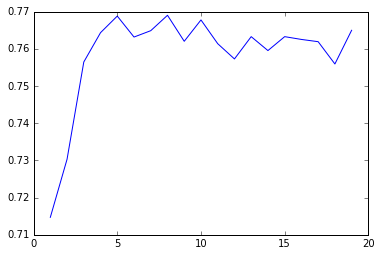

In [137]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

def makeitofsize(dathirdsize):
    allofthem = []
    for ii in range(40):
        neurnet = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(4,9,dathirdsize))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
        X_train, X_test = scaleData(X_train, X_test)
        neurnet.fit(X_train, y_train)
        allofthem.append(np.mean(neurnet.predict(X_test)==y_test))
    return np.mean(allofthem)

allthescores = [makeitofsize(jj) for jj in range(1,20)]
plt.plot(range(1,20),allthescores)

In [138]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

neurnet = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(100,10))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
# It's important to scale the data!
X_train, X_test = scaleData(X_train, X_test)
neurnet.fit(X_train, y_train)
np.mean(neurnet.predict(X_test)==y_test)

0.75035663338088443

#### Find ideal number of neighbors

In [16]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

numericdataframe = makeAllColumnsNumeric(thedataframe, dictofordinals, datacateg)[0]
frompredict = ['Pclass', 'Sex', "Age", 'SibSp', 'Parch', "Fare", "Cabin", 'Embarked']
#frompredict = ['Pclass', 'Sex', 'SibSp']

(X,y) = makeDataFromModels(numericdataframe, topredict, frompredict, {})
allscores = []
for jj in range(1,20):
    allscores.append(getPredictionScore(X, y, KNeighborsClassifier, num_iterations=30, transform="scale", n_neighbors=jj)[0])

# if we decrease wrt a value twice in a row, we've reached the max
bestnumneighbors = list(np.append(
    (np.array(allscores[2:]) - np.array(allscores[:-2]) < 0).astype(int), 
    1) * (np.array(allscores[1:]) - np.array(allscores[:-1]) < 0).astype(int)).index(1) + 1

Ideal number is 13


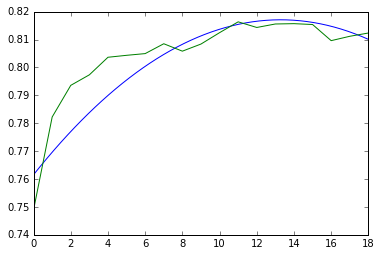

In [17]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

poly = PolynomialFeatures(degree=2)
polyX = poly.fit_transform((np.arange(len(allscores))+1).reshape(-1, 1))
linreg = LinearRegression()
linreg.fit(polyX,np.array(allscores).reshape(-1, 1))
xs = np.linspace(0,18)
plt.plot(xs, linreg.intercept_ + linreg.coef_[0][0] + linreg.coef_[0][1]*xs + linreg.coef_[0][2]*(xs**2))
plt.plot(allscores)
print "Ideal number is %d" %np.round(-linreg.coef_[0][1]/(2*linreg.coef_[0][2]))

### Ensemble
Will be useful when implementing voting methods

In [19]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

def getPredictAccur(predictionmethod):
    try:
        predictionaccuracy = allmodelsandresults[(getModelName(predictionmethod),polydegree)][-1][0]
    except KeyError:
        predictionaccuracy = allmodelsandresults[getModelName(predictionmethod)][0]
    return predictionaccuracy

# ================================================
# THESE FUNCTIONS ARE FOR ESTIMATING THE CORRECT VALUES BASED ON A BAYES-LIKE PROB OF THE RIGHT ANSWER
def getprob(result, event, prob):
    if result==event:
        chance = prob 
    else:
        chance = 1 - prob
    return chance

def getConsensusResult(resultlist, probs):
    prob1 = [getprob(result, 1,prob) for prob,result in zip(probs,resultlist)]
    prob0 = [getprob(result, 0,prob) for prob,result in zip(probs,resultlist)]
    #ratio = (np.mean(y)/(1-np.mean(y)))* np.prod(prob1)/np.prod(prob0)
    ratio = np.prod(prob1)/np.prod(prob0)
    probshouldbe1 = ratio / (1+ratio)
    consensusresult = np.round(probshouldbe1)
    return consensusresult
# ================================================

num_iterations = 10
polydegree = 2
modelstotryout = [RidgeCV, SGDRegressor, LogisticRegression, 
                  SVC, KNeighborsClassifier, NearestCentroid, RandomForestClassifier, ExtraTreesClassifier,
                  AdaBoostClassifier, GradientBoostingClassifier]

poly = PolynomialFeatures(degree=polydegree)
probs = [getPredictAccur(predictionmethod) for predictionmethod in modelstotryout]
totalvotes = np.sum(probs)
score = []
for iter in range(num_iterations):
    kfoldindices = KFold(len(y),n_folds=5,shuffle=True)
    for trainindex, testindex in kfoldindices:
        Xtrain, Xtest = X[trainindex], X[testindex]
        ytrain, ytest = y[trainindex], y[testindex]
        ensemblepredictions = []
        for predictionmethod in modelstotryout:
            if predictionmethod in [RidgeCV, SGDRegressor, LogisticRegressionCV]:
                Xtraintouse = poly.fit_transform(Xtrain)
                Xtesttouse = poly.fit_transform(Xtest)
            else:
                Xtraintouse, Xtesttouse = Xtrain, Xtest
            (Xtraintouse, Xtesttouse) = scaleData(Xtraintouse, Xtesttouse)
            #if predictionmethod==DecisionTreeClassifier:
            #    predictor = predictionmethod(max_depth=6, min_samples_leaf=5)
            #elif predictionmethod==KNeighborsClassifier:
            #    predictor = predictionmethod(n_neighbors=14)
            #else:
            #    predictor = predictionmethod()
            predictor = predictionmethod()
            predictor.fit(Xtraintouse,ytrain)
            predictionaccuracy = getPredictAccur(predictionmethod)
            prediction = np.round(predictor.predict(Xtesttouse), decimals=0)*predictionaccuracy
            ensemblepredictions.append(prediction)
        masterprediction = np.round(np.dot(np.transpose(np.array(ensemblepredictions)), 
                                           np.full(len(modelstotryout), 1.0)) / totalvotes)
        # ================================================
        # ALTERNATIVE METHOD, USING A BAYES-LIKE PROBABILITY ESTIMATE FOR WHICH ANSWER IS RIGHT
        #rounded = np.round(np.transpose(np.array(ensemblepredictions)))
        #masterprediction = np.array([getConsensusResult(resultlist,probs) for resultlist in rounded])
        # ================================================
        score.append(np.mean(masterprediction==ytest))
        
(np.mean(score),np.std(score))

(0.82166623376623382, 0.027986421212895671)

Will be useful when implementing voting methods

In [296]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

# HERE IS SOMETHING THAT DOES NEARLY EXACTLY THE SAME THING (EXCEPT A LESS PRECISE COMPUTATION OF SCORES)
def daname(clf):
    return str(clf)[:str(clf).index("(")]

Xscaled = scaleData(X,X)[0]

clf2 = LogisticRegression()
clf3 = SVC()
clf4 = KNeighborsClassifier()
clf5 = NearestCentroid()
clf6 = RandomForestClassifier(n_estimators=30)
clf7 = ExtraTreesClassifier()
clf8 = AdaBoostClassifier()
clf9 = GradientBoostingClassifier()
theweights = [allmodelsandresults[daname(clf)][0] for clf in [clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9]]
allscores = np.array([])
for ii in range(10):
    ensemble = VotingClassifier(estimators=[('2', clf2), ('3', clf3), ('4', clf4), ('5', clf5), 
                                        ('6', clf6), ('7', clf7), ('8', clf8), ('9', clf9)], voting='hard', weights=theweights)
    scores = cross_val_score(ensemble, Xscaled, y, cv=5)
    allscores = np.append(allscores,scores)
(np.mean(allscores), np.std(allscores))

NameError: name 'allmodelsandresults' is not defined

Will be useful when implementing voting methods

In [21]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

# IT WORKS ALSO WITH GRIDCV!
ensemble = VotingClassifier(estimators=[('2', clf2), ('3', clf3),  ('4', clf4),  ('5', clf5), 
                                        ('6', clf6), ('7', clf7), ('8', clf8), ('9', clf9)], voting='hard', weights=theweights)
params = [{'2__C': [1.0, 100.0], '6__n_estimators': [20, 100]}]
grid = GridSearchCV(estimator=ensemble, param_grid=params, cv=5)
np.mean(cross_val_score(grid, Xscaled, y, cv=5))

0.82535714285714301

## Semi-supervised
Semi-supervised methods are when we have a very small amount of labeled data. The way we label the rest of the data is by similarity, often using K-nearest-neighobrs. The unlabeled data should have the $y$-value set to -1

In [18]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

y_unlabeled = deepcopy(y)
# Now we hide 80% of the answers y, and see if we can predict them
indextoremovelabel = np.random.choice(range(len(y_unlabeled)), size=int(0.8*len(y_unlabeled)), replace=False)
y_unlabeled[indextoremovelabel] = -1

In [19]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

spreading = label_propagation.LabelSpreading(kernel='rbf')
spreading.fit(X, y_unlabeled)
print np.mean(spreading.transduction_==y) # The transduction attribute tells you what the predicted labels are

spreading = label_propagation.LabelSpreading(kernel='knn', n_neighbors=7)
spreading.fit(X, y_unlabeled)
print np.mean(spreading.transduction_==y)

propagation = label_propagation.LabelPropagation(kernel='rbf')
propagation.fit(X, y_unlabeled)
print np.mean(propagation.transduction_==y)

propagation = label_propagation.LabelPropagation(kernel='knn')
propagation.fit(X, y_unlabeled)
print np.mean(propagation.transduction_==y)

0.697488584475
0.728310502283
0.684931506849
0.681506849315


### Evaluate and improve Probability estimates

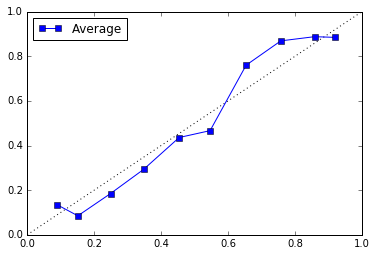

In [21]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

# When CalibratedClassifierCV fits the data it first splits it into 3 (or the number cv=#). It
# then leaves out one part, fits the estimator (e.g. Random Forests) to the rest, and evaluates
# the probabilities of the part left out. It then checks how good those probability estimates were,
# by checking whether those predicted with probability 0.1 really did happen 10% of the time etc.
# Once it knows how its probability estimates did it learns how to compensate for its estimates.
# This same procedure is cycled through all 3 folds. We have now created a set of 3 estimators, each
# one that knows how to compensate its probability predictions. 
# When we then use CalibratedClassifierCV to predict probabilities of a test set. Then, each of the
# 3 estimators independently estimates the probability, compensating in its own way, and the 
# average of these results is takes as the true estimate.
# If we want to set cv=1, i.e. to only have a single calibrated estimator, we just feed it
# an already-fitted base estimator and set cv="prefit". Then when we fit this calibrated
# estimator, we must use data that wasn't used to fit the base estimator. Finally, we 
# use yet-unseen data to set it, as normal.

est = RandomForestClassifier(n_estimators=10)
calibratediso = CalibratedClassifierCV(est, method='isotonic')
calibratedsig = CalibratedClassifierCV(est, method='sigmoid')

plt.plot([0,1],[0,1], "k:")
for clf in [est, calibratediso, calibratedsig]:
    clf.fit(X_train, y_train)
    prob_pos = clf.predict_proba(X_test)[:, 1]
    answers, probas = calibration_curve(y_test, prob_pos, n_bins=10)
    #plt.plot(probas, answers, "s-", label = daname(str(clf)))

averagecalibration = (calibratediso.predict_proba(X_test)+calibratedsig.predict_proba(X_test))/2.
answers, probas = calibration_curve(y_test, averagecalibration[:, 1], n_bins=10)
plt.plot(probas, answers, "s-", label = "Average")
plt.legend(loc="upper left")

## Unsupervised - Clustering

#### Evaluation of model - if cluster answer is known (i.e. we have a y)

In [20]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

# Check for each cluster what the average value of y is. Then check in the predicted test sample whether they have the
# same average value of y. Compute the difference between these two in each cluster and output the average and std.
def genericnumbererror(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
        X_train, X_test = scaleData(X_train, X_test)
        clf.fit(X_train)
        trainingmeans = np.array([np.mean([y_train[ii] for ii,label in enumerate(clf.predict(X_train)) if label==kk]) 
                                  for kk in list(set(clf.labels_))])
        testmeans = np.array([np.mean([y_test[ii] for ii,label in enumerate(clf.predict(X_test)) if label==kk])
                              for kk in list(set(clf.labels_))])
        mistake = trainingmeans - testmeans
        mistake = mistake[np.logical_not(np.isnan(mistake))]
        everything.append([np.mean(mistake), np.std(mistake)])
    return np.mean(np.array(everything)[:,0]), np.mean(np.array(everything)[:,1])

def genericnumbererrorFitPredict(method, **kwargs):
    everything = []
    for ij in range(20):
        clf = method(**kwargs)
        X_touse = scaleData(X,X)[0]
        X_1, X_2, y_1, y_2 = train_test_split(clf.fit_predict(X_touse), y, test_size=0.5)
        X1means = np.array([np.mean([y_1[ii] for ii,label in enumerate(X_1) if label==kk]) 
                                  for kk in list(set(np.append(X_1, X_2)))])
        X2means = np.array([np.mean([y_2[ii] for ii,label in enumerate(X_2) if label==kk]) 
                            for kk in list(set(np.append(X_1, X_2)))])
        mistake = X1means - X2means
        mistake = mistake[np.logical_not(np.isnan(mistake))]
        everything.append([np.mean(mistake), np.std(mistake)])
    return np.mean(np.array(everything)[:,0]), np.mean(np.array(everything)[:,1])

In [21]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

print genericnumbererror(KMeans, n_clusters=2) # Use MiniBatchKMeans is Kmeans is too slow
print genericnumbererror(AffinityPropagation)
print genericnumbererror(MeanShift)
print genericnumbererrorFitPredict(SpectralClustering)
print genericnumbererrorFitPredict(AgglomerativeClustering, n_clusters=2)
print genericnumbererrorFitPredict(DBSCAN)
print genericnumbererror(Birch)

(-0.0088139948430197099, 0.038286649811250455)
(-0.0063040219238520972, 0.19437928483556322)
(-0.010962148029796235, 0.22019678139891946)
(0.010560566640498321, 0.18641111774802366)
(0.011917019469566227, 0.030222250652409337)
(0.0043128022605910844, 0.2764772821286739)
(0.0013113583670082746, 0.065528009303564089)


In [22]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

# This is the benchmark we need to beat
allrandomdifferences = []
for ki in range(1000):
    y_1, y_2 = train_test_split(y, test_size=0.5)
    allrandomdifferences.append(np.mean(y_1)-np.mean(y_2))
np.mean(allrandomdifferences), np.std(allrandomdifferences)

(-0.0017123287671232869, 0.033198380409168643)

In [26]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

def clusteringscore(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
        X_train, X_test = scaleData(X_train, X_test)
        clf.fit(X_train)
        everything.append(metrics.adjusted_rand_score(clf.predict(X_test),y_test))
    return np.mean(everything), np.std(everything)

def clusteringscoreFitPredict(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_touse = scaleData(X,X)[0]
        everything.append(metrics.adjusted_rand_score(clf.fit_predict(X_touse),y))
    return np.mean(everything), np.std(everything)

print clusteringscore(KMeans, n_clusters=4) # Use MiniBatchKMeans is Kmeans is too slow
print clusteringscore(AffinityPropagation)
print clusteringscore(MeanShift)
print clusteringscoreFitPredict(SpectralClustering)
print clusteringscoreFitPredict(AgglomerativeClustering, n_clusters=2)
print clusteringscoreFitPredict(DBSCAN)
print clusteringscore(Birch)



(0.21896740080434574, 0.041872223168834086)
(0.083399264955473465, 0.012267988058495253)
(0.068619238199703531, 0.039482440468309114)
(0.045246755223383818, 0.00075654961222016348)
(0.11587725762719282, 0.0)
(0.042879931767859043, 6.9388939039072284e-18)
(0.10000698565833778, 0.027854063328773337)


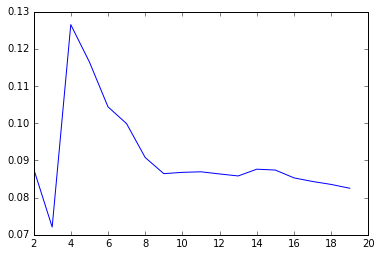

In [29]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

def clusteringscore(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
        X_train, X_test = scaleData(X_train, X_test)
        clf.fit(X_train)
        everything.append(metrics.homogeneity_score(clf.predict(X_test),y_test))
    return np.mean(everything), np.std(everything)

def clusteringscoreFitPredict(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_touse = scaleData(X,X)[0]
        everything.append(metrics.homogeneity_score(clf.fit_predict(X_touse),y))
    return np.mean(everything), np.std(everything)

#print clusteringscore(KMeans, n_clusters=4) # Use MiniBatchKMeans is Kmeans is too slow
#print clusteringscore(AffinityPropagation)
#print clusteringscore(MeanShift)
#print clusteringscoreFitPredict(SpectralClustering)
#print clusteringscoreFitPredict(AgglomerativeClustering, n_clusters=2)
#print clusteringscoreFitPredict(DBSCAN)
#print clusteringscore(Birch)
hoho = [clusteringscore(KMeans, n_clusters=kk)[0] for kk in range(2,20)]
plt.plot(range(2,20), hoho)

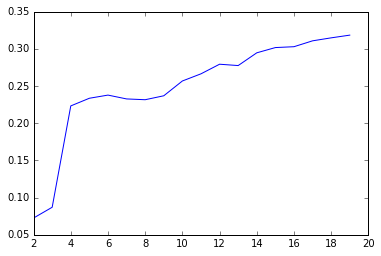

In [30]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

def clusteringscore(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
        X_train, X_test = scaleData(X_train, X_test)
        clf.fit(X_train)
        everything.append(metrics.completeness_score(clf.predict(X_test),y_test))
    return np.mean(everything), np.std(everything)

def clusteringscoreFitPredict(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_touse = scaleData(X,X)[0]
        everything.append(metrics.completeness_score(clf.fit_predict(X_touse),y))
    return np.mean(everything), np.std(everything)

#print clusteringscore(KMeans, n_clusters=4) # Use MiniBatchKMeans is Kmeans is too slow
#print clusteringscore(AffinityPropagation)
#print clusteringscore(MeanShift)
#print clusteringscoreFitPredict(SpectralClustering)
#print clusteringscoreFitPredict(AgglomerativeClustering, n_clusters=2)
#print clusteringscoreFitPredict(DBSCAN)
#print clusteringscore(Birch)
hoho = [clusteringscore(KMeans, n_clusters=kk)[0] for kk in range(2,20)]
plt.plot(range(2,20), hoho)

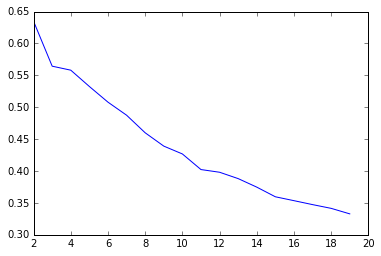

In [31]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

def clusteringscore(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
        X_train, X_test = scaleData(X_train, X_test)
        clf.fit(X_train)
        everything.append(metrics.fowlkes_mallows_score(clf.predict(X_test),y_test))
    return np.mean(everything), np.std(everything)

def clusteringscoreFitPredict(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_touse = scaleData(X,X)[0]
        everything.append(metrics.fowlkes_mallows_score(clf.fit_predict(X_touse),y))
    return np.mean(everything), np.std(everything)

#print clusteringscore(KMeans, n_clusters=4) # Use MiniBatchKMeans is Kmeans is too slow
#print clusteringscore(AffinityPropagation)
#print clusteringscore(MeanShift)
#print clusteringscoreFitPredict(SpectralClustering)
#print clusteringscoreFitPredict(AgglomerativeClustering, n_clusters=2)
#print clusteringscoreFitPredict(DBSCAN)
#print clusteringscore(Birch)
hoho = [clusteringscore(KMeans, n_clusters=kk)[0] for kk in range(2,20)]
plt.plot(range(2,20), hoho)

#### If cluster answer is not known (we do not have a y)
These metrics tell you whether your clusters and dense and separated, i.e. are well-defined clusters, when viewed from the perspective of the given model

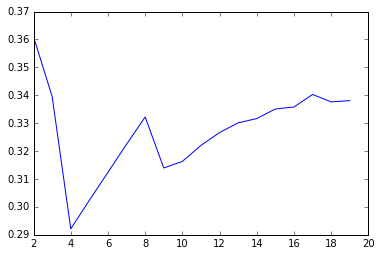

In [45]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

def clusteringscore(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_touse = scaleData(X, X)[0]
        clf.fit(X_touse)
        everything.append(metrics.silhouette_score(X_touse, clf.predict(X_touse)))
    return np.mean(everything), np.std(everything)

def clusteringscoreFitPredict(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_touse = scaleData(X,X)[0]
        everything.append(metrics.silhouette_score(X_touse, clf.fit_predict(X_touse)))
    return np.mean(everything), np.std(everything)

hoho = [clusteringscore(KMeans, n_clusters=kk)[0] for kk in range(2,20)]
plt.plot(range(2,20), hoho)

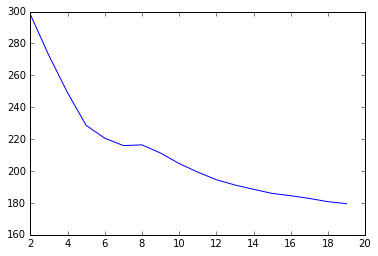

In [46]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

def clusteringscore(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_touse = scaleData(X, X)[0]
        clf.fit(X_touse)
        everything.append(metrics.calinski_harabaz_score(X_touse, clf.predict(X_touse)))
    return np.mean(everything), np.std(everything)

def clusteringscoreFitPredict(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_touse = scaleData(X,X)[0]
        everything.append(metrics.calinski_harabaz_score(X_touse, clf.fit_predict(X_touse)))
    return np.mean(everything), np.std(everything)

hoho = [clusteringscore(KMeans, n_clusters=kk)[0] for kk in range(2,20)]
plt.plot(range(2,20), hoho)

# Feature Engineering

In [21]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

numericdataframe = makeAllColumnsNumeric(thedataframe, dictofordinals, datacateg)[0]
topredict = "Survived"
frompredict = ['Sex', 'Fare', 'Pclass', 'Age', 'SibSp', 'Cabin', 'Embarked', 'Parch']
(X,y) = makeDataFromModels(numericdataframe, topredict, frompredict, {})

### Remove features uncorrelated with y
SelectKBest choses the $k$ columns in $X$ that are most correlated with the answer $y$, using as method to determine correlation anything we want. mutual_info_classif is a good default one: it uses KnearestNeighbors to determine how correlated things are.

In [17]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

numfeaturestokeep = 4 # tune this to whatever you like

# if predicting y is a regression rather than classification problem, we should use mutual_info_regression
X_reduced = SelectKBest(mutual_info_classif, k=numfeaturestokeep).fit_transform(X, y)

getPredictionScore(X_reduced, y, RandomForestClassifier, num_iterations=10, transform="none", n_estimators=30)

(0.80285454545454538, 0.029110362697740397)

Instead of taking all columns at once, we iteratively check which column is the worst predictor and remove it, until we have the desired number of features (in the case of RFE) or we have the ideal number of features (in the case o RFECV). You can pass both a regressor, with attribute coef\_, or a classifier that has the attribute feature\_importances\_  

In [48]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

estimator = LinearRegression()
selector = RFE(estimator, 5)
selector.fit(X, y)
print selector.score(X, y)
selector.support_ 

0.381556005259


array([ True, False,  True, False,  True,  True,  True, False], dtype=bool)

In [61]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

estimator = RandomForestClassifier(n_estimators=30)
selector = RFECV(estimator, cv=5)
selector.fit(X, y)
print cross_val_score(selector, X, y, cv=5)
selector.support_

[ 0.77272727  0.81714286  0.82857143  0.76        0.87428571]


array([ True,  True,  True,  True, False,  True, False, False], dtype=bool)

### Use trees to find feature importances
zzzzzzzzz Will be useful to plot later zzzzzzzzzzzzzz

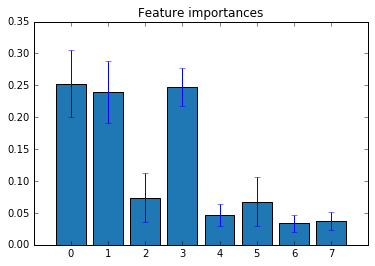

In [81]:
forest = RandomForestClassifier(n_estimators=200)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances,
       color=darkBrewerColors(1), yerr=std, align="center")
plt.xticks(range(X.shape[1]), )
plt.xlim([-1, X.shape[1]])
plt.show()

### Feature selection functions

In [121]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

# With a given list frompredict, it will return the subset of the entries in frompredict that yield
# the best prediction with the model predictionmethod.
def bestFeatureSet(numericdataframe, topredict, frompredict, predictionmethod,
                   dictofunknown={}, num_iterations=100, transform="none"):
    bestscore = 0
    bestsubset = []
    for ii in range(1,len(frompredict)):
        allsubsets = findsubsets(frompredict,ii)
        allsubsets = [list(subset) for subset in allsubsets]
        for subset in allsubsets:
            (X,y) = makeDataFromModels(numericdataframe, topredict, subset, dictofunknown)
            score = getPredictionScore(X, y, predictionmethod, num_iterations=num_iterations, transform=transform)
            if score[0]>bestscore:
                bestscore = score[0]
                bestsubset = subset
    return bestsubset

### Dimensional reduction functions

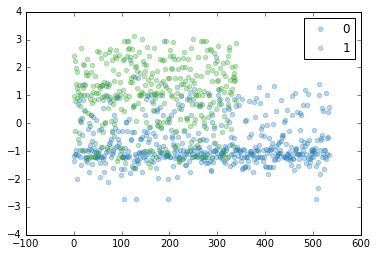

In [92]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

# LDA is supervised, PCA is not. LDA tries to separate the classes as much as possible from each other while doing dim red;
# PCA tries to separate the data as much as possible from itself (no labels) when doing dim red.
def dimensionalReductionLDA(X, y):
    clf = LinearDiscriminantAnalysis(n_components=2)
    clf.fit(X,y)
    trans_X = clf.transform(X)
    uniquevalues = list(set(y))
    for ii in uniquevalues:
        if trans_X.shape[1]==1:
            xaxisnumbers = range(len(trans_X[y==ii]))
            yaxisnumbers = trans_X[y==ii, 0]
        else:
            xaxisnumbers = trans_X[y==ii, 0]
            yaxisnumbers = trans_X[y==ii, 1]
        plt.scatter(xaxisnumbers, yaxisnumbers, alpha=0.3, color=darkBrewerColors()[ii], label=ii)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    

dimensionalReductionLDA(X,y)

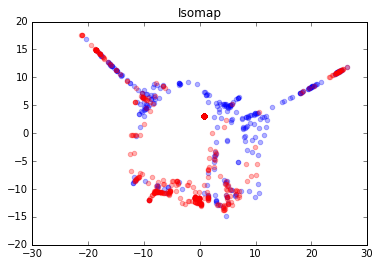

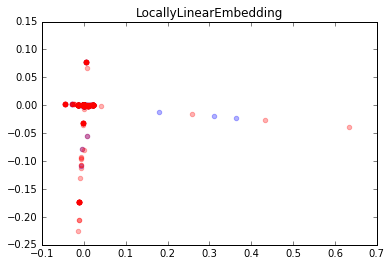

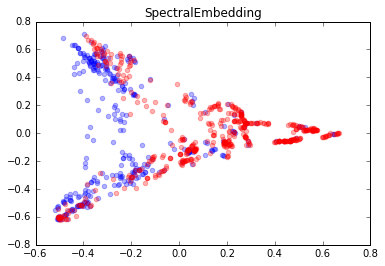

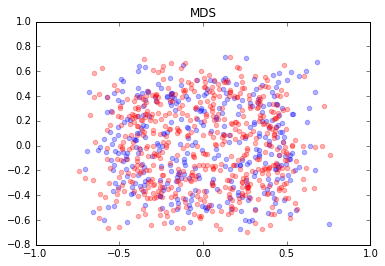

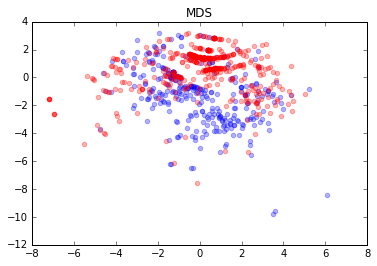

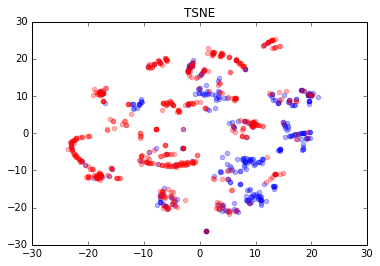

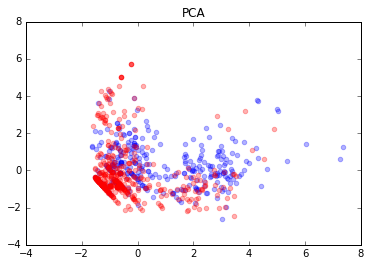

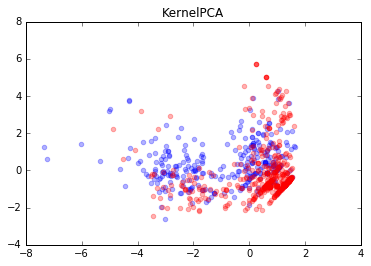

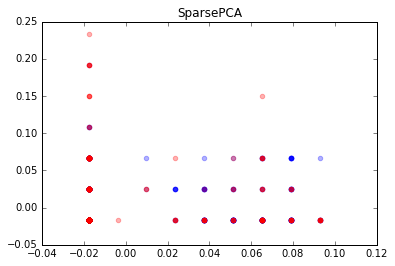

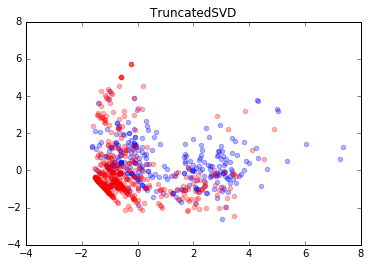

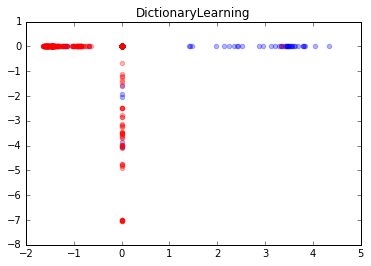

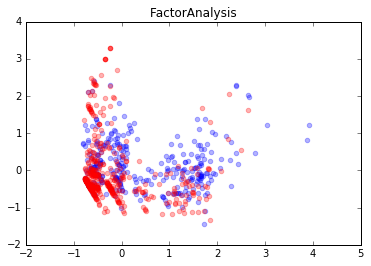

In [31]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

X_touse = scaleData(X,X)[0]
def plot2d(chosenmodel, **kwargs):
    clf = chosenmodel(**kwargs)
    newX = clf.fit_transform(X_touse)
    madeit = newX[np.where(y==1)[0]]
    notmadeit = newX[np.where(y==0)[0]]
    plt.scatter(madeit[:,0],madeit[:,1], color="b", alpha=0.3)
    plt.scatter(notmadeit[:,0],notmadeit[:,1], color="r", alpha=0.3)
    plt.title(getModelName(chosenmodel))
    plt.show()
    
plot2d(Isomap, n_neighbors=3) #Maintains geodesic distances between nearby points, "unravelling" the whole manifold
plot2d(LocallyLinearEmbedding, n_neighbors=5) #Locally maints distances, "unravelling" the manifold in 
                                               #a similar but different way to Isomap
plot2d(SpectralEmbedding, affinity="nearest_neighbors") #Takes the dominant eigenvectors of the Laplacian matrix
plot2d(MDS, metric=False) #Is good at preserving the hierarchy of distances of the high-dim space
plot2d(MDS) #Is good at preserving distances of the high-dim space
plot2d(TSNE) #Is good at preserving local structure - it focuses on the  details of the high-dim space. It can deal
             #with multiple, disjoint manifolds
plot2d(PCA)
plot2d(KernelPCA) 
plot2d(SparsePCA) 
plot2d(TruncatedSVD)
plot2d(DictionaryLearning) 
plot2d(FactorAnalysis)

## Novelty detection

zzzzzzzzz This will be useful later zzzzzzzzzzzzzzzzzzzz

In [91]:
clf = OneClassSVM()
clf.fit(X_touse[nonoutliers][:770])
clf.predict(X_touse[nonoutliers][770:])

array([-1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
        1., -1., -1., -1.,  1.])

# Good code setup examples (extra tidbits)

In [18]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))
cross_val_score(clf, X, y, cv=5)
cross_val_predict(clf, X, y, cv=5)

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 1,

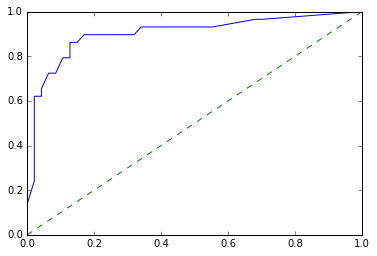

0.902787967718


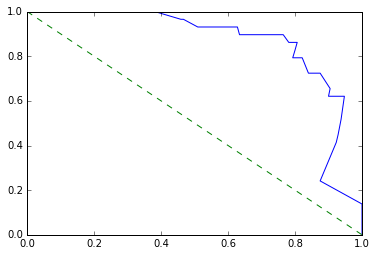

In [164]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score

clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
clf.fit(X[:800], y[:800])
y_pred = clf.predict(X[800:])
y_pred_prob = clf.predict_proba(X[800:])[:,1]
confusion_matrix(y[800:], y_pred)
def plotROC(y_true, y_pred_prob):
    roc = roc_curve(y_true, y_pred_prob)
    plt.plot(roc[0], roc[1])
    plt.plot([0,1],[0,1], linestyle="dashed")
    plt.show()
    
def plotPrecisionRecall(y_true, y_pred_prob):
    prec_rec = precision_recall_curve(y_true, y_pred_prob)
    plt.plot(prec_rec[0], prec_rec[1])
    plt.plot([0,1],[1,0], linestyle="dashed")
    plt.show()
    
plotROC(y[800:], y_pred_prob)
print roc_auc_score(y[800:], y_pred_prob)

plotPrecisionRecall(y[800:], y_pred_prob)

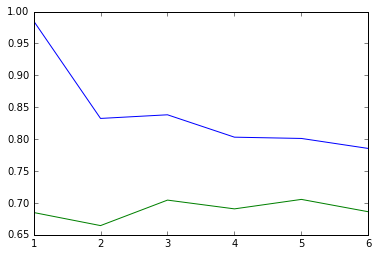

In [179]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

from sklearn.model_selection import validation_curve

# TELLS YOU WHERE TO CAP THE COMPLEXITY OF YOUR MODEL, FOR THE GIVEN AMOUNT OF DATA

valuestotake = range(1,7)
train_scores, valid_scores = validation_curve(KNeighborsClassifier(), X, y, "n_neighbors", range(1,7), cv=5)
plt.plot(valuestotake, [np.mean(el) for el in train_scores])
plt.plot(valuestotake, [np.mean(el) for el in valid_scores])

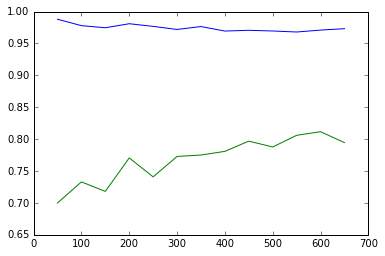

In [43]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

# TELLS YOU WHETHER, FOR A GIVEN MODEL COMPLEXITY, YOU BENEFIT FROM ADDING SAMPLES. IF THE ANSWER
# IS NO, YOU MIGHT WANT TO INCREASE THE COMPLEXITY OF THE MODEL

train_sizes, train_scores, valid_scores = learning_curve(RandomForestClassifier(), X, y, 
                                                         train_sizes=np.arange(50,700, 50).astype(int), cv=5)
plt.plot(train_sizes, [np.mean(el) for el in train_scores])
plt.plot(train_sizes, [np.mean(el) for el in valid_scores])

## Making new features and unions of various features
zzzzzzzz This might be useful zzzzzzzzzzzzzzz

In [52]:
from sklearn.pipeline import Pipeline, FeatureUnion

# This dataset is way too high-dimensional. Better do PCA:
pca = PCA(n_components=2)

# Maybe some original features where good, too?
selection = SelectKBest(k=2)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)
X_features

array([[-25.73157975,  -7.00490097,   3.        ,   1.        ],
       [ 38.86276366,   7.46413053,   1.        ,   0.        ],
       [-24.95258973,  -3.01210462,   3.        ,   0.        ],
       ..., 
       [ -9.33090363,   0.2063422 ,   3.        ,   0.        ],
       [ -2.71292814,  -3.35321257,   1.        ,   1.        ],
       [-24.9663326 ,   2.98714632,   3.        ,   1.        ]])

# Saving prediction classifiers to disk

In [166]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

import pickle
from sklearn.externals import joblib
joblib.dump(clf, 'filename.pkl')
#clf = joblib.load('filename.pkl')  #FOR LOADING

['filename.pkl']

In [20]:
#======================================================================
#======================================================================
#========================PROBABLY OBSOLETE CELL========================
#======================================================================
#======================================================================

np.log1p(-1)

-inf

##### Still to do:

zzzzzzzzzzzzzzzzzzzzz Check this list zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz

 - Make a generic evaluaion of how each model did. It should include confusion matrices, ROC curves, time it takes to .fit (or possibly it's better to do "speed"= # of examples/time), time it takes to .predict (or perhaps "speed" again), accuracy (.score for supervised, various metrics."scoringmethod" for unsupervied), plot of heteroscedasticity, plot of calibrated probability esimates
 - Compare with histograms etc. the various models against each other, and draw a horizontal line in the histograms where the benchmark value is, i.e. the score of a "random prediction"
 - Check what else we did during S2DS